# Итоговый проект

Здравствуйте, Ксения Викторовна! Это мой проект, приятной проверки!

P.S. каждый раз при запуске программа собирает по `API` разные данные. Поэтому я оставила все резлуьтаты работы в `output`. Если Вы запустите программу, то выводы в `markdown` могут отличаться от того, что будет выведено в датасете(

![Бабочка](project_pictures/бабочка.gif)

<a id='0'></a>
## Содержание

1. [Про API](#1)
2. [Достаём данные](#2)
3. [Чистим данные](#3)
4. [О датасете](#4)
5. [Анализ](#5)
    * [Каких людей в первую очередь записывали в раздел `people` в Гарварде](#5.1)
    * [Какие техники выполнения были присущи тем или иным культурам](#5.2)
    * [Сколько лет в среднем уходило создание экспоната каждой категории](#5.3)
    * [Цветовые палитры культур](#5.4)
    * [Департаменты экспонатов](#5.5)
    * [Должности `people`](#5.6)
    * [Плодотворность года](#5.7)
6. [Выводы](#6)

<a id='1'></a>
## [Про API](#0)

Небольшое предисловие про мои метания и поиcки данных через `API`. Конечно же было интересно скачать не готовый и уже организованный в `CSV` файл датасет, а что-то сделать самой. Тем более что с `json` у меня не было как такового опыта работы, поэтому это был вызов самой себе.

Сначала я хотела взять что-то про библиотеки. В голове была картинка датасета с демографией пользователей бибилиотеки, что и сколько раз они брали, жанр книг, которые они взяли, срок и так далее. Но, к сожалению, такие данные я найти не смогла (что было очень грустно).

Во второй раз я решила, что хочу достать данные с какого-нибудь маркетплэйса. На просторах интернета мне попался мини-туториал по извлечению данных с `Amazon`, так что я загорелась этой идеей, но в процессе регистрации поняла, что будучи гражданином РФ не могу завершить этот процесс...

![Амазон](project_pictures/amazon.jpg)

Поразмыслив ещё, я решила поработать с данными о погоде. В идеале хотелось, чтобы в данных были указаны города, сторона света и , конечно, много данных о самой погоде. В целом, я нашла порталы, на которых можно было получить такие данные: [Открытая погодная карта](https://openweathermap.org/) и [Яндекс Погода](https://yandex.ru/dev/weather/?ysclid=lu89ytjoov345494690).

Проблема первого сайта - ограничение по тарифам. Для получения хороших данных нужно было заплатить, а такой возможности у меня не было. Хотя я пыталась( То же самое было и с Яндекс.Погода. Хотите хорошие данные за 70 лет? Переведите денежку на карту)))))) Поэтому я принялась искать дальше.

Я всё же решила вернуться к направлению библиотек, искусства и вообще мест, где могут быть собраны категориальные, числовые и другие данные. Были попытки достать что-то из Ленинской библиотеки, библиотеки им. Некрасова, но они не увенчались успехом.

И вот, моё спасение: [The Harvard Art Museums](https://harvardartmuseums.org/). Прекрасный сайт, прекрасное направление деятельности и, самое главное, наличие бесплатного и полностью открытого `API` и данных! 

Я заполнила нужную форму, получила `API` и пошла читать информацию с [github](https://github.com/harvardartmuseums/api-docs?tab=readme-ov-file#access-to-the-api), на котором была написана вся основная информация, в том числе, какие конкретно данные можно получить через API.

**В общем, охота удалась!**

Через сам `API` можно было достать просто нереально огромное кол-во информации. Можно было изначально корректировать запрос по `API` и доставать только определённые секции данных (а их было 26, по несколько (от 5) подразделений в каждой)

<a id='2'></a>
## [Достаём данные](#0)

Для начала импортирую все библиотеки, которые мне понадобятся в проекте.

In [1]:
import requests
import pandas as pd
import numpy as np
import json
import random

# отключаю всякие предупреждения
import warnings
warnings.filterwarnings('ignore')

Ставлю настройку, чтобы у меня всегда показывались ВСЕ столбцы датафрейма. Так как из-за некоторого ограничения `pandas` иногда выводятся не все.

In [4]:
pd.set_option('display.max_columns', None)

Итак, первая сложность возникла уже на стадии извлечения данных.

За один раз можно было достать через `API` максимум `100 строк` (что, конечно, очень мало для проекта). Но это можно было скорректировать параметр `page` (это как раз было написано на `github` в разделе [Paging through data](https://github.com/harvardartmuseums/api-docs?tab=readme-ov-file#access-to-the-api:~:text=%22aggregations%22%3A%20%7B%0A%0A%20%20%20%20%7D%0A%7D-,Paging%20through%20data,-Requests%20that%20return)). Чтобы решить эту проблему, я запустила цикл `for` для нужного кол-ва страниц — я решила взять 150 страниц, по 50 записей из каждой. При этом это были случайные страницы, так как изначально данные упорядочены и данные были немного однотонны. Хотелось охватить как можно большее кол-во страниц с разными данными.

Так, например, когда я брала первые 60 страниц, в колонке `period` было только одно уникальное значение. Работать с таким не очень инетерсно, да и не репрезентативно.

Второй момент, который нужно было учитывать, это то, что без указания нужных данных через параметр `fields`, программа выводит все 68 колонок, которые только есть в данных. 
1. не все колонки нужны для анализа
2. некоторые из них полностью пустые
так что я решила, что лучше сразу максимально отфильтровать датасет и вывести только самое нужное.

Уточню, что их всех возможных значений в строке `"https://api.harvardartmuseums.org/xxx"` я выбрала `OBJECT`. Мой выбор пал именно на него, потому что при вызове `OBJECT` я получала всю-всю информацию, которую можно достать отдельно через другие значения (типа `period`, `place` и так далее).

Ещё один параметр, который я указала при извлечении данных: `verificationlevel`

![Уровень проработки](project_pictures/verification.png)
Чтобы из моих данных (после чистки) не осталось слишком мало, я сразу указала качество объектов, которые я хочу получить.

P.S. я один раз создала диапазон из 150 чисел и сохранила его в отдельную переменную. Сам код заключила в комментарий, чтобы случайно не запустить его и не сломать всю систему.

In [ ]:
# создаю случайный диапазон из 60 чисел, номера страниц
# random_numbers = random.sample(range(1, 2447), 150)
# random_numbers

In [2]:
pages = [380, 1671, 906, 1994, 1859, 540, 2033, 2149, 1153, 2199, 1489, 753, 657, 1765, 1722, 2127, 299, 1345, 2174, 59, 1011, 145, 1879, 867, 1367, 364, 1185, 1607, 2201, 2332, 859, 1999, 1430, 1871, 2137, 2352, 1888, 933, 1425, 392, 309, 1822, 1333, 508, 496, 2003, 1903, 2315, 424, 1409, 387, 2390, 1456, 1939, 1932, 1979, 1973, 161, 1748, 2339, 771, 1599, 2117, 1055, 663, 340, 2157, 46, 851, 210, 1622, 708, 1744, 455, 658, 1387, 1861, 1848, 2442, 1800, 105, 485, 1018, 1402, 2267, 1936, 604, 2089, 2399, 121, 874, 1834, 120, 1568, 721, 1612, 2417, 153, 1548, 1692, 2063, 38, 1907, 1756, 2264, 885, 1514, 2129, 1091, 326, 1312, 878, 648, 2410, 347, 1401, 2075, 2342, 1029, 1197, 221, 2098, 925, 56, 1941, 839, 1252, 486, 1753, 831, 1015, 219, 694, 24, 2355, 1784, 2353, 90, 211, 458, 1746, 1061, 2166, 487, 1219, 1853, 1512, 1669, 191, 254]

In [3]:
# функция для извлечения данных из API
def fetch_data_from_api():
    base_url = "https://api.harvardartmuseums.org/OBJECT"
    api_key = "3865d98f-d4cd-4bf6-b43e-b932808eedab"
    
    # список для сохранения записей
    all_records = []
    
    # цикл по всем страницам данных
    for page in pages:
        
        # параметры запроса
        params = {
            
            # API
            "apikey": '3865d98f-d4cd-4bf6-b43e-b932808eedab',
            
            # номер страницы
            "page": page,
            
            # кол-вао записей на странице (100 - максимально возможное)
            "size": 50,
            
            # уровень проработанности данных
            'verificationlevel': 4,
            
            # нужные поля данных
            'fields': 'division,colorcount,id,period,accessionyear,classification,technique,title,accessionmethod,colors,department,datebegin,dateend,culture,people'
        }
        
        # делаю get запрос к API
        response = requests.get(base_url, params=params)
        
        # если запрос успешный, данные извлекаются из JSON-ответа и добавляются в список all_records
        if response.status_code == 200:
            records = response.json()['records']
            all_records.extend(records)

    # возвращаю список all_records со всеми записями
    return all_records

# преобразовываю все записи в DataFrame
def convert_to_dataframe(records):
    return pd.DataFrame(records)

if __name__ == "__main__":
    data = fetch_data_from_api()
    df = convert_to_dataframe(data)
    df.to_json('data_2.json', orient='records', lines=True, force_ascii=False)

In [5]:
# вывожу начало датафрейма

df.head()

,period,accessionyear,technique,dateend,classification,title,people,accessionmethod,division,datebegin,culture,imagepermissionlevel,colorcount,id,department,colors
0,None,1925.0,Etching,0,Prints,Design for a chimneypiece,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57510,Department of Prints,NaN
1,None,1925.0,Etching,0,Prints,Design for a chimneypiece and two consoles,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57511,Department of Prints,NaN
2,None,1925.0,Etching,0,Prints,Design for a chimneypiece in Egyptian style,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57512,Department of Prints,NaN
3,None,1925.0,Etching,0,Prints,Portrait of an Old Man,"[{'role': 'Artist', 'birthplace': None, 'gende...",Gift,European and American Art,0,Italian,0,0,57513,Department of Prints,NaN
4,None,1925.0,Etching,0,Prints,Virgin presenting Christ to Angels,"[{'role': 'Artist', 'birthplace': 'Florence, I...",Gift,European and American Art,0,Italian,0,0,57514,Department of Prints,NaN


Следующая сложность — вложенность структур. 

В моём датафрейме есть 2 столбца, в которых содержат части `json`. Они, к сожалению, автоматически не преобразовались в отдельные колонки и ячейки. Поэтому мне нужно сделать это отдельно.

**Информация о создателе**

In [9]:
# создаю пустой DataFrame, в который буду добавлять данные
result_df = pd.DataFrame()

# прохожусь по всем строчкам столбца 'people'
for i in range(len(df['people'])):
    
    # проверяю, пустая ли ячейка
    # есть ячейки, в который 2 словаря, поэтому проверяю, что все элементы ячейки пустые np.all
    if np.all(pd.isnull(df['people'][i])):
        
        # если ячейка пустая, создаю временный DataFrame temp_df, содержащий только NaN и имеющий ту же структуру столбцов, что и DataFrame df
        temp_df = pd.DataFrame([np.nan] * len(df.columns)).T
        
    # если ячеёка НЕ пустая  
    else:
        
        # извлекаю первый словарь (если вдруг их там два)
        dic_people = df['people'].iloc[i][0] 
        # преобразовываю словарь в ячейку
        temp_df = pd.DataFrame(dic_people, index=[0])
        
    # объединяю датафреймы и начинаю индексацию строк с 0 
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

# вывожу результат
result_df.head()

,role,birthplace,gender,displaydate,prefix,culture,displayname,alphasort,name,personid,deathplace,displayorder,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Artist,None,male,c. 1735 - 1808,None,Italian,Giovanni Ottaviani,"Ottaviani, Giovanni",Giovanni Ottaviani,32740.0,None,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Artist,"Florence, Italy",male,1727 - 1815,None,Italian,Francesco Bartolozzi,"Bartolozzi, Francesco",Francesco Bartolozzi,31178.0,"Lisbon, Portugal",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим, что у нас образовалось очень много пустых столбцов. Они нам ни к чему, поэтому их нужно удалить.

ТО есть сейчас буду удалять все столбцы до столбца `displayorder` (не включительно, так как столбец неинформативный)

In [10]:
#  нахожу индекс столбца 'displayorder'
displayorder_index = result_df.columns.get_loc('displayorder')

# выбираю все столбцы до 'displayorder'
result_df = result_df.iloc[:, :displayorder_index]

# вывожу результат
result_df.head()

,role,birthplace,gender,displaydate,prefix,culture,displayname,alphasort,name,personid,deathplace
0,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy"
1,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy"
2,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy"
3,Artist,None,male,c. 1735 - 1808,None,Italian,Giovanni Ottaviani,"Ottaviani, Giovanni",Giovanni Ottaviani,32740.0,None
4,Artist,"Florence, Italy",male,1727 - 1815,None,Italian,Francesco Bartolozzi,"Bartolozzi, Francesco",Francesco Bartolozzi,31178.0,"Lisbon, Portugal"


Объединяю получившиеся датасеты.

In [13]:
merged_df = pd.concat([df, result_df], axis=1)
merged_df.head()

,period,accessionyear,technique,dateend,classification,title,people,accessionmethod,division,datebegin,culture,imagepermissionlevel,colorcount,id,department,colors,role,birthplace,gender,displaydate,prefix,culture,displayname,alphasort,name,personid,deathplace
0,None,1925.0,Etching,0,Prints,Design for a chimneypiece,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57510,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy"
1,None,1925.0,Etching,0,Prints,Design for a chimneypiece and two consoles,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57511,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy"
2,None,1925.0,Etching,0,Prints,Design for a chimneypiece in Egyptian style,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57512,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy"
3,None,1925.0,Etching,0,Prints,Portrait of an Old Man,"[{'role': 'Artist', 'birthplace': None, 'gende...",Gift,European and American Art,0,Italian,0,0,57513,Department of Prints,NaN,Artist,None,male,c. 1735 - 1808,None,Italian,Giovanni Ottaviani,"Ottaviani, Giovanni",Giovanni Ottaviani,32740.0,None
4,None,1925.0,Etching,0,Prints,Virgin presenting Christ to Angels,"[{'role': 'Artist', 'birthplace': 'Florence, I...",Gift,European and American Art,0,Italian,0,0,57514,Department of Prints,NaN,Artist,"Florence, Italy",male,1727 - 1815,None,Italian,Francesco Bartolozzi,"Bartolozzi, Francesco",Francesco Bartolozzi,31178.0,"Lisbon, Portugal"


**Цвета объекта**

Аналогичную процедуру проделываю со столбцом `colors`. Единственное, в каждой ячейке было несколько словарей сразу, одинакового формата вида
```
"colors":[
    {"color":"#e1c8c8","spectrum":"#c15689","hue":"Orange","percent":0.52625,"css3":"#d8bfd8"},  {"color":"#c8c896","spectrum":"#a9cf38","hue":"Green","percent":0.4043452381,"css3":"#d2b48c"},{"color":"#96967d","spectrum":"#8e5ea7","hue":"Green","percent":0.0449404762,"css3":"#808080"},{"color":"#191919","spectrum":"#1eb264","hue":"Grey","percent":0.0102380952,"css3":"#000000"},{"color":"#190000","spectrum":"#2eb45d","hue":"Black","percent":0.0094047619,"css3":"#000000"},{"color":"#64644b","spectrum":"#59ba4a","hue":"Green","percent":0.00375,"css3":"#696969"},{"color":"#4b4b32","spectrum":"#4ab851","hue":"Green","percent":0.0010714286,"css3":"#556b2f"}
    ]
```

Из этих данных я решила достать все `color` и записать в одну ячейку через запятую.

In [14]:
# функция для извлечения значения 'color' из каждой ячейки столбца 'colors'
def extract_colors(row):
    if isinstance(row['colors'], list):
        colors_list = [color_dict.get('color') for color_dict in row['colors']]
        return ', '.join(filter(None, colors_list))
    else:
        return None

# создаю новый столбец 'combined_colors' с объединенными значениями цветов
merged_df['combined_colors'] = df.apply(extract_colors, axis=1)

# объединяю новый столбец 'combined_colors' с исходным датафреймом 'df'
merged_df_2 = pd.concat([merged_df, merged_df['combined_colors']], axis=1)

# вывожу результат
merged_df_2.head()

,period,accessionyear,technique,dateend,classification,title,people,accessionmethod,division,datebegin,culture,imagepermissionlevel,colorcount,id,department,colors,role,birthplace,gender,displaydate,prefix,culture,displayname,alphasort,name,personid,deathplace,combined_colors,combined_colors
0,None,1925.0,Etching,0,Prints,Design for a chimneypiece,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57510,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None,None
1,None,1925.0,Etching,0,Prints,Design for a chimneypiece and two consoles,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57511,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None,None
2,None,1925.0,Etching,0,Prints,Design for a chimneypiece in Egyptian style,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57512,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None,None
3,None,1925.0,Etching,0,Prints,Portrait of an Old Man,"[{'role': 'Artist', 'birthplace': None, 'gende...",Gift,European and American Art,0,Italian,0,0,57513,Department of Prints,NaN,Artist,None,male,c. 1735 - 1808,None,Italian,Giovanni Ottaviani,"Ottaviani, Giovanni",Giovanni Ottaviani,32740.0,None,None,None
4,None,1925.0,Etching,0,Prints,Virgin presenting Christ to Angels,"[{'role': 'Artist', 'birthplace': 'Florence, I...",Gift,European and American Art,0,Italian,0,0,57514,Department of Prints,NaN,Artist,"Florence, Italy",male,1727 - 1815,None,Italian,Francesco Bartolozzi,"Bartolozzi, Francesco",Francesco Bartolozzi,31178.0,"Lisbon, Portugal",None,None


Отлично! Мы достали основные данные)

<a id='3'></a>
## [Чистим данные](#0)

Теперь займёмся чисткой данных. Столбцов у нас много, поэтому следует посмотреть на них и убрать те, которые нам всё же будут чересчур сложны в интерпретации (для моего уровня владения навыками анализа данных) и неинформативны.

Чтобы в дальнейшем иметь возможность сравнить датасеты, сохраню датасет для очистки в новую переменную.

In [30]:
df_to_clean = merged_df_2.copy()
df_to_clean.head()

,period,accessionyear,technique,dateend,classification,title,people,accessionmethod,division,datebegin,culture,imagepermissionlevel,colorcount,id,department,colors,role,birthplace,gender,displaydate,prefix,culture,displayname,alphasort,name,personid,deathplace,colors_of_object,combined_colors
0,None,1925.0,Etching,0,Prints,Design for a chimneypiece,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57510,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None,None
1,None,1925.0,Etching,0,Prints,Design for a chimneypiece and two consoles,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57511,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None,None
2,None,1925.0,Etching,0,Prints,Design for a chimneypiece in Egyptian style,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57512,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None,None
3,None,1925.0,Etching,0,Prints,Portrait of an Old Man,"[{'role': 'Artist', 'birthplace': None, 'gende...",Gift,European and American Art,0,Italian,0,0,57513,Department of Prints,NaN,Artist,None,male,c. 1735 - 1808,None,Italian,Giovanni Ottaviani,"Ottaviani, Giovanni",Giovanni Ottaviani,32740.0,None,None,None
4,None,1925.0,Etching,0,Prints,Virgin presenting Christ to Angels,"[{'role': 'Artist', 'birthplace': 'Florence, I...",Gift,European and American Art,0,Italian,0,0,57514,Department of Prints,NaN,Artist,"Florence, Italy",male,1727 - 1815,None,Italian,Francesco Bartolozzi,"Bartolozzi, Francesco",Francesco Bartolozzi,31178.0,"Lisbon, Portugal",None,None


1. **дублирующиеся столбцы и строки**

При извлечении `color` и создании столюца `combined_colors` я создала два одинаковых столбца. Нам будет достаточно одного, поэтому уберём самый последний из них.

Так как их 2, методы типа `drop` удаляют оба сразу. Поэтому сначала я переименую предпоследний.

In [31]:
df_to_clean.columns.values[-2] = 'colors_of_object'
df_to_clean.iloc[0 : 2]

,period,accessionyear,technique,dateend,classification,title,people,accessionmethod,division,datebegin,culture,imagepermissionlevel,colorcount,id,department,colors,role,birthplace,gender,displaydate,prefix,culture,displayname,alphasort,name,personid,deathplace,colors_of_object,combined_colors
0,None,1925.0,Etching,0,Prints,Design for a chimneypiece,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57510,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None,None
1,None,1925.0,Etching,0,Prints,Design for a chimneypiece and two consoles,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57511,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None,None


In [32]:
df_to_clean.drop('combined_colors', axis=1, inplace = True)
df_to_clean.head()

,period,accessionyear,technique,dateend,classification,title,people,accessionmethod,division,datebegin,culture,imagepermissionlevel,colorcount,id,department,colors,role,birthplace,gender,displaydate,prefix,culture,displayname,alphasort,name,personid,deathplace,colors_of_object
0,None,1925.0,Etching,0,Prints,Design for a chimneypiece,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57510,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None
1,None,1925.0,Etching,0,Prints,Design for a chimneypiece and two consoles,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57511,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None
2,None,1925.0,Etching,0,Prints,Design for a chimneypiece in Egyptian style,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57512,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None
3,None,1925.0,Etching,0,Prints,Portrait of an Old Man,"[{'role': 'Artist', 'birthplace': None, 'gende...",Gift,European and American Art,0,Italian,0,0,57513,Department of Prints,NaN,Artist,None,male,c. 1735 - 1808,None,Italian,Giovanni Ottaviani,"Ottaviani, Giovanni",Giovanni Ottaviani,32740.0,None,None
4,None,1925.0,Etching,0,Prints,Virgin presenting Christ to Angels,"[{'role': 'Artist', 'birthplace': 'Florence, I...",Gift,European and American Art,0,Italian,0,0,57514,Department of Prints,NaN,Artist,"Florence, Italy",male,1727 - 1815,None,Italian,Francesco Bartolozzi,"Bartolozzi, Francesco",Francesco Bartolozzi,31178.0,"Lisbon, Portugal",None


Аналогичная ситуация со столбцом `culture`.

In [33]:
df_to_clean.columns.values[10] = 'primary_culture'
df_to_clean.iloc[0 : 2]

,period,accessionyear,technique,dateend,classification,title,people,accessionmethod,division,datebegin,primary_culture,imagepermissionlevel,colorcount,id,department,colors,role,birthplace,gender,displaydate,prefix,culture,displayname,alphasort,name,personid,deathplace,colors_of_object
0,None,1925.0,Etching,0,Prints,Design for a chimneypiece,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57510,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None
1,None,1925.0,Etching,0,Prints,Design for a chimneypiece and two consoles,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57511,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Italian,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None


In [34]:
df_to_clean.drop('culture', axis=1, inplace = True)
df_to_clean.head()

,period,accessionyear,technique,dateend,classification,title,people,accessionmethod,division,datebegin,primary_culture,imagepermissionlevel,colorcount,id,department,colors,role,birthplace,gender,displaydate,prefix,displayname,alphasort,name,personid,deathplace,colors_of_object
0,None,1925.0,Etching,0,Prints,Design for a chimneypiece,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57510,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None
1,None,1925.0,Etching,0,Prints,Design for a chimneypiece and two consoles,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57511,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None
2,None,1925.0,Etching,0,Prints,Design for a chimneypiece in Egyptian style,"[{'role': 'Artist', 'birthplace': 'Mogliano Ve...",Gift,European and American Art,0,Italian,0,0,57512,Department of Prints,NaN,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,None,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,28089.0,"Rome, Italy",None
3,None,1925.0,Etching,0,Prints,Portrait of an Old Man,"[{'role': 'Artist', 'birthplace': None, 'gende...",Gift,European and American Art,0,Italian,0,0,57513,Department of Prints,NaN,Artist,None,male,c. 1735 - 1808,None,Giovanni Ottaviani,"Ottaviani, Giovanni",Giovanni Ottaviani,32740.0,None,None
4,None,1925.0,Etching,0,Prints,Virgin presenting Christ to Angels,"[{'role': 'Artist', 'birthplace': 'Florence, I...",Gift,European and American Art,0,Italian,0,0,57514,Department of Prints,NaN,Artist,"Florence, Italy",male,1727 - 1815,None,Francesco Bartolozzi,"Bartolozzi, Francesco",Francesco Bartolozzi,31178.0,"Lisbon, Portugal",None


Также проверю и удалю повторябщиеся строки в столбце `id`

In [35]:
df_to_clean['id'].shape[0]

7500

In [36]:
df_to_clean = df_to_clean.drop_duplicates('id')
df_to_clean.shape[0]

7474

2. **удаление столбцов**

Изначально у нас было 2 `json` столбца, из которых я извлекала данные. Так как я уже привели их в удобный для чтения вид, изначальные столбцы можно удалить. Работать с ними уже неудобно.

Также удалю столбцы `prefix`, `imagepermissionlevel` и `personid` (неинформативный).

In [37]:
# уникальные значения `prefix`
df_to_clean['prefix'].unique()

array([None, nan, 'Moneyer:', 'Issued by', 'After the issue of',
       'Traditional attribution to', 'Attributed to', '?', 'Negative by',
       'Designed by', 'Possibly attributable to', 'Calligraphy by',
       'After', 'Published by', 'Circle of', 'Engraved by', 'Workshop of',
       'Traditionally attributed to', 'Imitator of', 'Possibly by',
       'Manner of', 'Follower of', 'School of', 'Signed by', 'after',
       'Ascribed to', 'Manufactured by', 'Calligraphy attributed to',
       'Modelled by', 'Probably Manufactured by', 'Modelled by?',
       'Illustrated by'], dtype=object)

In [38]:
df_to_clean.drop(['people', 'colors', 'prefix', 'imagepermissionlevel', 'personid'], axis=1, inplace = True)
df_to_clean.head()

,period,accessionyear,technique,dateend,classification,title,accessionmethod,division,datebegin,primary_culture,colorcount,id,department,role,birthplace,gender,displaydate,displayname,alphasort,name,deathplace,colors_of_object
0,None,1925.0,Etching,0,Prints,Design for a chimneypiece,Gift,European and American Art,0,Italian,0,57510,Department of Prints,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,"Rome, Italy",None
1,None,1925.0,Etching,0,Prints,Design for a chimneypiece and two consoles,Gift,European and American Art,0,Italian,0,57511,Department of Prints,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,"Rome, Italy",None
2,None,1925.0,Etching,0,Prints,Design for a chimneypiece in Egyptian style,Gift,European and American Art,0,Italian,0,57512,Department of Prints,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,Giovanni Battista Piranesi,"Piranesi, Giovanni Battista",Giovanni Battista Piranesi,"Rome, Italy",None
3,None,1925.0,Etching,0,Prints,Portrait of an Old Man,Gift,European and American Art,0,Italian,0,57513,Department of Prints,Artist,None,male,c. 1735 - 1808,Giovanni Ottaviani,"Ottaviani, Giovanni",Giovanni Ottaviani,None,None
4,None,1925.0,Etching,0,Prints,Virgin presenting Christ to Angels,Gift,European and American Art,0,Italian,0,57514,Department of Prints,Artist,"Florence, Italy",male,1727 - 1815,Francesco Bartolozzi,"Bartolozzi, Francesco",Francesco Bartolozzi,"Lisbon, Portugal",None


3. **столбцы с именами**

У меня есть 3 похожих столбца `displayname`, `alphasort`, `name` в которых в целом содержится одно и то же, но в разном виде. 

Что написано про это на [Github](https://github.com/harvardartmuseums/api-docs/blob/master/sections/person.md#:~:text=a%20specific%20person.-,alphasort,-describes%20the%20form):
* `alphasort` describes the form of the persons name useful for sorting names alphabetically. This often takes the form of "lastname, firstname" and is our preferred way to sort names.

* `displayname` describes the form of the persons name used for display purposes. This often takes the form of "firstname lastname" and is our preferred way to display names.

* `names` describes the variant names of the person. A person may have one or more names.

Последний вариант (`names`) мне не подходит, так как в ячейке может содержаться сразу много значений, что усложнит работу над данными. Второй и первый варианты удобны, так как унифицируют запись этих данных (фамилия, имя; имя, фамилия), и в целом взаимозаменяемые. Я предпочитаю порядок, поэтому оставлю столбец `alphasort`.

In [39]:
df_to_clean.drop(['displayname', 'name'], axis=1, inplace = True)
df_to_clean.head()

,period,accessionyear,technique,dateend,classification,title,accessionmethod,division,datebegin,primary_culture,colorcount,id,department,role,birthplace,gender,displaydate,alphasort,deathplace,colors_of_object
0,None,1925.0,Etching,0,Prints,Design for a chimneypiece,Gift,European and American Art,0,Italian,0,57510,Department of Prints,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,"Piranesi, Giovanni Battista","Rome, Italy",None
1,None,1925.0,Etching,0,Prints,Design for a chimneypiece and two consoles,Gift,European and American Art,0,Italian,0,57511,Department of Prints,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,"Piranesi, Giovanni Battista","Rome, Italy",None
2,None,1925.0,Etching,0,Prints,Design for a chimneypiece in Egyptian style,Gift,European and American Art,0,Italian,0,57512,Department of Prints,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,"Piranesi, Giovanni Battista","Rome, Italy",None
3,None,1925.0,Etching,0,Prints,Portrait of an Old Man,Gift,European and American Art,0,Italian,0,57513,Department of Prints,Artist,None,male,c. 1735 - 1808,"Ottaviani, Giovanni",None,None
4,None,1925.0,Etching,0,Prints,Virgin presenting Christ to Angels,Gift,European and American Art,0,Italian,0,57514,Department of Prints,Artist,"Florence, Italy",male,1727 - 1815,"Bartolozzi, Francesco","Lisbon, Portugal",None


4. **разделение ячеек**

У меня есть ячейки типа `birthplace` и `deathplace`. В них содержатся данные, который вполне можно разделить на разные столбцы. Предлагаю этим и заняться.

* *birthplace*

Формат записи: город, страна. По такому принципу и поделим на два новых столбца `birth_city` и `birth_country`.

In [40]:
# делю строки методом split() по запятой с пробелом
# expand=True указывает, что результат деления должен быть в вите датафрейма со значениями в отдельных столбцах
# n=1 для случаев, если встречается больше одной запятой

df_to_clean[['birth_city', 'birth_country']] = df_to_clean['birthplace'].str.split(', ', n=1, expand=True)
df_to_clean.head()

,period,accessionyear,technique,dateend,classification,title,accessionmethod,division,datebegin,primary_culture,colorcount,id,department,role,birthplace,gender,displaydate,alphasort,deathplace,colors_of_object,birth_city,birth_country
0,None,1925.0,Etching,0,Prints,Design for a chimneypiece,Gift,European and American Art,0,Italian,0,57510,Department of Prints,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,"Piranesi, Giovanni Battista","Rome, Italy",None,Mogliano Veneto,Italy
1,None,1925.0,Etching,0,Prints,Design for a chimneypiece and two consoles,Gift,European and American Art,0,Italian,0,57511,Department of Prints,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,"Piranesi, Giovanni Battista","Rome, Italy",None,Mogliano Veneto,Italy
2,None,1925.0,Etching,0,Prints,Design for a chimneypiece in Egyptian style,Gift,European and American Art,0,Italian,0,57512,Department of Prints,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,"Piranesi, Giovanni Battista","Rome, Italy",None,Mogliano Veneto,Italy
3,None,1925.0,Etching,0,Prints,Portrait of an Old Man,Gift,European and American Art,0,Italian,0,57513,Department of Prints,Artist,None,male,c. 1735 - 1808,"Ottaviani, Giovanni",None,None,None,None
4,None,1925.0,Etching,0,Prints,Virgin presenting Christ to Angels,Gift,European and American Art,0,Italian,0,57514,Department of Prints,Artist,"Florence, Italy",male,1727 - 1815,"Bartolozzi, Francesco","Lisbon, Portugal",None,Florence,Italy


* *deathplace*

Аналогично: `death_city` и `death_country`.

In [41]:
df_to_clean[['death_city', 'death_country']] = df_to_clean['deathplace'].str.split(', ', n=1, expand=True)
df_to_clean.head()

,period,accessionyear,technique,dateend,classification,title,accessionmethod,division,datebegin,primary_culture,colorcount,id,department,role,birthplace,gender,displaydate,alphasort,deathplace,colors_of_object,birth_city,birth_country,death_city,death_country
0,None,1925.0,Etching,0,Prints,Design for a chimneypiece,Gift,European and American Art,0,Italian,0,57510,Department of Prints,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,"Piranesi, Giovanni Battista","Rome, Italy",None,Mogliano Veneto,Italy,Rome,Italy
1,None,1925.0,Etching,0,Prints,Design for a chimneypiece and two consoles,Gift,European and American Art,0,Italian,0,57511,Department of Prints,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,"Piranesi, Giovanni Battista","Rome, Italy",None,Mogliano Veneto,Italy,Rome,Italy
2,None,1925.0,Etching,0,Prints,Design for a chimneypiece in Egyptian style,Gift,European and American Art,0,Italian,0,57512,Department of Prints,Artist,"Mogliano Veneto, Italy",male,1720 - 1778,"Piranesi, Giovanni Battista","Rome, Italy",None,Mogliano Veneto,Italy,Rome,Italy
3,None,1925.0,Etching,0,Prints,Portrait of an Old Man,Gift,European and American Art,0,Italian,0,57513,Department of Prints,Artist,None,male,c. 1735 - 1808,"Ottaviani, Giovanni",None,None,None,None,None,None
4,None,1925.0,Etching,0,Prints,Virgin presenting Christ to Angels,Gift,European and American Art,0,Italian,0,57514,Department of Prints,Artist,"Florence, Italy",male,1727 - 1815,"Bartolozzi, Francesco","Lisbon, Portugal",None,Florence,Italy,Lisbon,Portugal


При этом есть столбец, который (по началу) также хочется разделить на разные столбцы, но если мы посмотрим на его уникальные значения, т поймём, что просто так этого не сделать.

In [42]:
df_to_clean['displaydate'].unique()

array(['1720 - 1778', 'c. 1735 - 1808', '1727 - 1815', '1932 - 2007', nan,
       'active 1755 - 1796', '1757 - 1821', None, 'r. c. 330-300 BCE',
       '83-30 BCE', 'r. 244 - 249 CE', '217-218 CE', 'r. 285-246 BCE',
       'r. 246-221 BCE', 'r. 51-30 BCE', 'r. 37 - 41 CE',
       'r. 27 BCE - 14 CE', 'r. 14-37 CE', 'r. 41 - 54 CE',
       'r. 14 - 19 CE', 'r. 98-117 CE', 'r. 253 - 268 CE', 'active 1940s',
       'active 1930s', '1760 - 1849', '1752 - 1815', '1798 - 1861',
       '1797 - 1858', '1936 - 1994', '1898 - 1969', '1808-1879',
       'active 20th century', '1897 - 1951', 'born 1942', '1933 - 2023',
       'born 1948', 'born 1953', '1819 - 1889', '1804 - 1867',
       '1871 - 1956', '1943 - 1987', '1826 - 1869', '1769 - 1825',
       '1726 - 1792', '1743 - 1812', 'd. 1806', '1686 - 1764',
       '1735 - 1790', 'active c. 1704 - 1718', '1725-1770', '1298 - 1356',
       '1805 - 1876', 'active 1794 - 1795', '1664 - 1729', 'born 1941',
       '19th century', '20th century', '1822

5. **порядок столбцов**

При извлечении данных нужные мне поля лишь указывали компьютеру, какие данные нужно достать, но не указывало, в каком порядке их нужно построить.

In [43]:
df_to_clean.columns

Index(['period', 'accessionyear', 'technique', 'dateend', 'classification',
       'title', 'accessionmethod', 'division', 'datebegin', 'primary_culture',
       'colorcount', 'id', 'department', 'role', 'birthplace', 'gender',
       'displaydate', 'alphasort', 'deathplace', 'colors_of_object',
       'birth_city', 'birth_country', 'death_city', 'death_country'],
      dtype='object')

После того, как мы произвели чистку (настолько, насколько могли), стоит поменять порядок столбцов:
```
id
classification
title
datebegin
dateend
accessionyear
accessionmethod
period
primary_culture
technique
colorcount
colors_of_object
division
department
alphasort
role
displaydate
birthplace
birth_city
birth_country
deathplace
death_country
```

In [44]:
desired_column_order = [
    'id', 'classification', 'title', 'datebegin', 'dateend', 'accessionyear',
    'accessionmethod', 'period', 'primary_culture', 'technique', 'colorcount',
    'colors_of_object', 'division', 'department', 'alphasort', 'role',
    'displaydate', 'birthplace', 'birth_city', 'birth_country', 'deathplace',
    'death_country'
]

df_to_clean = df_to_clean[desired_column_order]
df_to_clean.head()

,id,classification,title,datebegin,dateend,accessionyear,accessionmethod,period,primary_culture,technique,colorcount,colors_of_object,division,department,alphasort,role,displaydate,birthplace,birth_city,birth_country,deathplace,death_country
0,57510,Prints,Design for a chimneypiece,0,0,1925.0,Gift,None,Italian,Etching,0,None,European and American Art,Department of Prints,"Piranesi, Giovanni Battista",Artist,1720 - 1778,"Mogliano Veneto, Italy",Mogliano Veneto,Italy,"Rome, Italy",Italy
1,57511,Prints,Design for a chimneypiece and two consoles,0,0,1925.0,Gift,None,Italian,Etching,0,None,European and American Art,Department of Prints,"Piranesi, Giovanni Battista",Artist,1720 - 1778,"Mogliano Veneto, Italy",Mogliano Veneto,Italy,"Rome, Italy",Italy
2,57512,Prints,Design for a chimneypiece in Egyptian style,0,0,1925.0,Gift,None,Italian,Etching,0,None,European and American Art,Department of Prints,"Piranesi, Giovanni Battista",Artist,1720 - 1778,"Mogliano Veneto, Italy",Mogliano Veneto,Italy,"Rome, Italy",Italy
3,57513,Prints,Portrait of an Old Man,0,0,1925.0,Gift,None,Italian,Etching,0,None,European and American Art,Department of Prints,"Ottaviani, Giovanni",Artist,c. 1735 - 1808,None,None,None,None,None
4,57514,Prints,Virgin presenting Christ to Angels,0,0,1925.0,Gift,None,Italian,Etching,0,None,European and American Art,Department of Prints,"Bartolozzi, Francesco",Artist,1727 - 1815,"Florence, Italy",Florence,Italy,"Lisbon, Portugal",Portugal


6. **унификация пропущенных значений**

Я заметила, что в моих столбцах есть 2 вида обозначения отсутстия данных: None и NaN. При этом компьютер видит их по-разному. 

Также в файле Гарварда некоторые отсутствующие значения обозначались как 0.

Поэтому, я унифицирую обозначение пропущенных значений по всему dataframe, чтобы они в будущем нам также не препятствовали, и заменю все пропущенные значения на 0.

In [45]:
df_to_clean.replace({None: 0}, inplace=True)
df_to_clean.replace({np.nan: 0}, inplace=True)

7. **тип данных**

В столбце с годом `accessionyer` у меня присутствовали пропущенные значения типа `NaN`, поэтому весь столбец становаится типа `float`. Исправлю это.

In [46]:
df_to_clean['accessionyear'] = df_to_clean['accessionyear'].astype(int)

**парочка слов о чистке**

Конечно, моя очистка датасета неидельна. К сожалению, моих навыков пока что не хватает, чтобы, например, унифицировать `displaydate` и `period`, поэтому я буду учитывать этот момент в дальнейшем анализе.

In [48]:
# сохраняю чистый датасет в новую переменную

clean = df_to_clean.copy()
clean.head()

,id,classification,title,datebegin,dateend,accessionyear,accessionmethod,period,primary_culture,technique,colorcount,colors_of_object,division,department,alphasort,role,displaydate,birthplace,birth_city,birth_country,deathplace,death_country
0,57510,Prints,Design for a chimneypiece,0,0,1925,Gift,0,Italian,Etching,0,0,European and American Art,Department of Prints,"Piranesi, Giovanni Battista",Artist,1720 - 1778,"Mogliano Veneto, Italy",Mogliano Veneto,Italy,"Rome, Italy",Italy
1,57511,Prints,Design for a chimneypiece and two consoles,0,0,1925,Gift,0,Italian,Etching,0,0,European and American Art,Department of Prints,"Piranesi, Giovanni Battista",Artist,1720 - 1778,"Mogliano Veneto, Italy",Mogliano Veneto,Italy,"Rome, Italy",Italy
2,57512,Prints,Design for a chimneypiece in Egyptian style,0,0,1925,Gift,0,Italian,Etching,0,0,European and American Art,Department of Prints,"Piranesi, Giovanni Battista",Artist,1720 - 1778,"Mogliano Veneto, Italy",Mogliano Veneto,Italy,"Rome, Italy",Italy
3,57513,Prints,Portrait of an Old Man,0,0,1925,Gift,0,Italian,Etching,0,0,European and American Art,Department of Prints,"Ottaviani, Giovanni",Artist,c. 1735 - 1808,0,0,0,0,0
4,57514,Prints,Virgin presenting Christ to Angels,0,0,1925,Gift,0,Italian,Etching,0,0,European and American Art,Department of Prints,"Bartolozzi, Francesco",Artist,1727 - 1815,"Florence, Italy",Florence,Italy,"Lisbon, Portugal",Portugal


<a id='4'></a>
## [О датасете](#0)

Теперь посмотрим на наш датасет с глобальной точки зрения.

In [49]:
clean.head()

,id,classification,title,datebegin,dateend,accessionyear,accessionmethod,period,primary_culture,technique,colorcount,colors_of_object,division,department,alphasort,role,displaydate,birthplace,birth_city,birth_country,deathplace,death_country
0,57510,Prints,Design for a chimneypiece,0,0,1925,Gift,0,Italian,Etching,0,0,European and American Art,Department of Prints,"Piranesi, Giovanni Battista",Artist,1720 - 1778,"Mogliano Veneto, Italy",Mogliano Veneto,Italy,"Rome, Italy",Italy
1,57511,Prints,Design for a chimneypiece and two consoles,0,0,1925,Gift,0,Italian,Etching,0,0,European and American Art,Department of Prints,"Piranesi, Giovanni Battista",Artist,1720 - 1778,"Mogliano Veneto, Italy",Mogliano Veneto,Italy,"Rome, Italy",Italy
2,57512,Prints,Design for a chimneypiece in Egyptian style,0,0,1925,Gift,0,Italian,Etching,0,0,European and American Art,Department of Prints,"Piranesi, Giovanni Battista",Artist,1720 - 1778,"Mogliano Veneto, Italy",Mogliano Veneto,Italy,"Rome, Italy",Italy
3,57513,Prints,Portrait of an Old Man,0,0,1925,Gift,0,Italian,Etching,0,0,European and American Art,Department of Prints,"Ottaviani, Giovanni",Artist,c. 1735 - 1808,0,0,0,0,0
4,57514,Prints,Virgin presenting Christ to Angels,0,0,1925,Gift,0,Italian,Etching,0,0,European and American Art,Department of Prints,"Bartolozzi, Francesco",Artist,1727 - 1815,"Florence, Italy",Florence,Italy,"Lisbon, Portugal",Portugal


In [50]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7474 entries, 0 to 7499
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                7474 non-null   int64 
 1   classification    7474 non-null   object
 2   title             7474 non-null   object
 3   datebegin         7474 non-null   int64 
 4   dateend           7474 non-null   int64 
 5   accessionyear     7474 non-null   int32 
 6   accessionmethod   7474 non-null   object
 7   period            7474 non-null   object
 8   primary_culture   7474 non-null   object
 9   technique         7474 non-null   object
 10  colorcount        7474 non-null   int64 
 11  colors_of_object  7474 non-null   object
 12  division          7474 non-null   object
 13  department        7474 non-null   object
 14  alphasort         7474 non-null   object
 15  role              7474 non-null   object
 16  displaydate       7474 non-null   object
 17  birthplace    

Видим, что в основном в колонках большая часть значений заполнены однако этого мы достигли засчёт замены `NaN` на `0`. 

Так что попробуем посмотреть на пропущенные значение другим способом.

In [51]:
(clean == 0).sum()

id                     0
classification         0
title                  0
datebegin           1792
dateend             1793
accessionyear       1620
accessionmethod      756
period              5735
primary_culture      172
technique           2627
colorcount           558
colors_of_object     558
division              98
department             0
alphasort           1354
role                1347
displaydate         2430
birthplace          4147
birth_city          4147
birth_country       4463
deathplace          4456
death_country       4674
dtype: int64

Так, теперь видим, что данных, конечно, всё же не так много. К сожалению, очень много пропущенных данных, несмотря на то, что в самом начале я укаpывала `verificationlevel` равный 4, что соответсвовало высокому качеству проработки данных. Но ничего не поделаешь. Будем работать так.

In [52]:
print(f'В изначальном датасете {merged_df_2.shape[0]} строк')
print(f'В изначальном датасете {merged_df_2.shape[1]} столбцов')
print()
print(f'В чистом датасете {clean.shape[0]} строк')
print(f'В чистом датасете {clean.shape[1]} столбца')

В изначальном датасете 7500 строк
В изначальном датасете 29 столбцов

В чистом датасете 7474 строк
В чистом датасете 22 столбца


In [53]:
# уникальные значения в каждом столбце
clean.nunique()

id                  7474
classification        40
title               5921
datebegin            700
dateend              679
accessionyear        108
accessionmethod       10
period               116
primary_culture       93
technique            107
colorcount            11
colors_of_object    6086
division               4
department            13
alphasort            943
role                   7
displaydate          742
birthplace           342
birth_city           312
birth_country        115
deathplace           184
death_country         58
dtype: int64

<a id='5'></a>
## [Анализ](#0)

И вот, с достаточно чистыми данными я готова провести анализ и сделать какие-то содержательные выводы.

Посмотрим на данные и построим разные таблички.

<a id='5.1'></a>
### [Каких людей в первую очередь записывали в раздел `people` в Гарварде](#0)

В первую очередь, так как из всех словарей, которые были в ячейках столбца `people` я брала только первого человека.

In [54]:
clean['role'].value_counts()

Artist              5592
0                   1347
Coin Constituent     523
Manufacturer           6
Publisher              3
Artist after           2
Designer               1
Name: role, dtype: int64

Чаще всего в датасете встречаются именно художники. На втором месте по количеству — `coin constituent`. К сожалению, я не нашла расшифровку данного значения в файле на `github`. Попробуем отфильтровать датасет по `classification = coins`.

In [61]:
clean[(clean['role'] == 'Coin Constituent')  & (clean['alphasort'] == 'Nero')]

,id,classification,title,datebegin,dateend,accessionyear,accessionmethod,period,primary_culture,technique,colorcount,colors_of_object,division,department,alphasort,role,displaydate,birthplace,birth_city,birth_country,deathplace,death_country
2065,196647,Coins,"As of Nero, Lugdunum",66,68,1976,Unidentified,"Roman Imperial period, Early",Roman Imperial,Struck,7,"#000000, #4b3232, #644b32, #7d644b, #190000, #...",Asian and Mediterranean Art,Department of Ancient and Byzantine Art & Numi...,Nero,Coin Constituent,r. 54 - 68 CE,0,0,0,0,0
2732,197308,Coins,"Sestertius of Nero, Rome",63,63,1942,Gift,"Roman Imperial period, Early",Roman Imperial,Struck,5,"#000000, #4b3232, #644b32, #7d6464, #190000",Asian and Mediterranean Art,Department of Ancient and Byzantine Art & Numi...,Nero,Coin Constituent,r. 54 - 68 CE,0,0,0,0,0
3988,195530,Coins,Sestertius of Nero with bird's-eye view of the...,64,64,1942,Gift,"Roman Imperial period, Early",Roman Imperial,Struck,8,"#afafaf, #323219, #4b3232, #644b32, #969696, #...",Asian and Mediterranean Art,Department of Ancient and Byzantine Art & Numi...,Nero,Coin Constituent,r. 54 - 68 CE,0,0,0,0,0
4141,141361,Coins,"As of Nero, Rome",65,65,2002,Bequest,"Roman Imperial period, Early",Roman Imperial,Struck,5,"#000000, #64644b, #7d7d64, #000019, #967d7d",Asian and Mediterranean Art,Department of Ancient and Byzantine Art & Numi...,Nero,Coin Constituent,r. 54 - 68 CE,0,0,0,0,0
5111,196011,Coins,"As of Nero, Lugdunum",66,66,1976,Transfer,"Roman Imperial period, Early",Roman Imperial,Struck,9,"#000000, #4b3232, #644b4b, #7d644b, #967d64, #...",Asian and Mediterranean Art,Department of Ancient and Byzantine Art & Numi...,Nero,Coin Constituent,r. 54 - 68 CE,0,0,0,0,0
5118,196018,Coins,"Dupondius of Nero, Rome",64,64,1976,Unidentified,"Roman Imperial period, Early",Roman Imperial,Struck,6,"#000000, #323232, #7d644b, #967d64, #000019, #...",Asian and Mediterranean Art,Department of Ancient and Byzantine Art & Numi...,Nero,Coin Constituent,r. 54 - 68 CE,0,0,0,0,0
5119,196019,Coins,"As of Nero, Rome",65,65,1976,Unidentified,"Roman Imperial period, Early",Roman Imperial,Struck,5,"#000000, #4b4b32, #64644b, #7d7d64, #000019",Asian and Mediterranean Art,Department of Ancient and Byzantine Art & Numi...,Nero,Coin Constituent,r. 54 - 68 CE,0,0,0,0,0
7394,186468,Coins,"Sestertius of Nero, Rome",65,68,2008,Transfer,"Roman Imperial period, Early",Roman Imperial,Struck,3,"#000000, #190000, #000019",Asian and Mediterranean Art,Department of Ancient and Byzantine Art & Numi...,Nero,Coin Constituent,r. 54 - 68 CE,0,0,0,0,0


В целом, с помощью яндекс переводчика и общего понимания датасета понятно, что человек с ролью `coin constituent` имел отношение к созданию этого экспоната. Моё предположение подтвердилось, когда я перешла по ссылке (реомендованой на `github`) [с фотографией экспоната](https://harvardartmuseums.org/collections/object/195530) (в конце указан `id` предмета из перовго столбца).

На монете изображён `Nero`. То есть `coin constituent` - тот, кто хоть как-то связан с монетой (изображёгн на неё, а может отдавал приказ о её чеканке)

То есть `role` человека сопоставима с классификацей объекта, что логично. Давайте выведем это соотношение.

In [62]:
correlation = clean.groupby(['role', 'classification'])['classification'].count().reset_index(name='count')
correlation

,role,classification,count
0,0,Albums,6
1,0,Amulets,1
2,0,Architectural Elements,5
3,0,Armor,3
4,0,Artists' Tools,58
...,...,...,...
70,Manufacturer,Medals and Medallions,3
71,Manufacturer,Sculpture,2
72,Manufacturer,Vessels,1
73,Publisher,Books,1


In [63]:
# словарь для role и классификации экспонатов
d = {}

# для подсчёта категорий
cnt = 0

# записываю значения (classification) в словарь
for i in range(len(correlation)):
    d[correlation.iloc[i][0]] = d.get(correlation.iloc[i][0], []) + [correlation.iloc[i][1]]

# вывожу отформатированный результат
for role, items in d.items():
    print(f'Роль: {role}\nКатегории экспонатов: {", ".join(items)}\nКол-во категорий экспонатов: {len(items)}\n')
    cnt += len(items)

Роль: 0
Категории экспонатов: Albums, Amulets, Architectural Elements, Armor, Artists' Tools, Books, Boxes, Brick Stamps, Calligraphy, Coins, Drawings, Fragments, Furnishings, Furniture, Jewelry, Lighting Devices, Manuscripts, Material Specimens, Medals and Medallions, Mosaics, Paintings, Paintings with Calligraphy, Photographs, Plaques, Prints, Recreational Artifacts, Riding Equipment, Ritual Implements, Sculpture, Seals, Textile Arts, Tools and Equipment, Vessels, Weapons and Ammunition
Кол-во категорий экспонатов: 34

Роль: Artist
Категории экспонатов: Albums, Architectural Elements, Archival Material, Artists' Tools, Books, Boxes, Calligraphy, Cameos, Coins, Drawings, Fragments, Furniture, Gems, Jewelry, Lighting Devices, Manuscripts, Medals and Medallions, Models, Multiples, Paintings, Paintings with Calligraphy, Photographs, Plaques, Portfolios, Prints, Recreational Artifacts, Sculpture, Textile Arts, Tools and Equipment, Vessels
Кол-во категорий экспонатов: 30

Роль: Artist afte

Есть определённые закономерности, однако они не очень точные. То есть человек, относязийся к экспонату классификации `Prints` мог быть и `Publisher`, и `Author`, и `Artist`. Тем не менее это всё же достаточно логично соотносится.

Но такая неоднозначность классификации всё же немного препятствует анализу.

In [64]:
print(f'Всего категорий в словаре d: {cnt}')

print(f'Всего картегорий в датасете: {clean["classification"].nunique()}')

Всего категорий в словаре d: 75
Всего картегорий в датасете: 40


Если бы не было таких неоднозначностей с соотнесением классификации и роли человека, то пропущенные значения `role` можно было бы заполнить (даже `Coins` не всегда гласят о `role` `Coin Constituent`)

<a id='5.2'></a>
### [Какие техники выполнения были присущи тем или иным культурам](#0)

In [76]:
correlation_2 = clean.groupby(['primary_culture', 'technique'])['technique'].count().reset_index(name='count')
correlation_2

,primary_culture,technique,count
0,0,0,33
1,0,Albumen silver print,22
2,0,Chromogenic print,15
3,0,Cibachrome (TM),3
4,0,Gelatin silver print,58
...,...,...,...
312,Turkish,0,3
313,Turkish,Woven,1
314,Unidentified culture,0,14
315,Unidentified culture,Struck,3


In [77]:
# словарь для primary_culture и техник экспонатов
d_2 = {}

# для подсчёта категорий
cnt_2 = 0

# записываю значения в словарь
for i in range(len(correlation_2)):
    d_2[correlation_2.iloc[i][0]] = d_2.get(correlation_2.iloc[i][0], []) + [str(correlation_2.iloc[i][1])]

no_techniques = []

# вывожу отформатированный результат
for culture, techniques in d_2.items():
    if len(techniques) == 1 and '0' in techniques:
        no_techniques.append(culture)
    else:
        print(f'Культура: {culture}\nТехника экспонатов: {", ".join(techniques)}\nКол-во техник экспонатов: {len(techniques)}\n')

Культура: 0
Техника экспонатов: 0, Albumen silver print, Chromogenic print, Cibachrome (TM), Gelatin silver print, Negative, gelatin silver (35mm film), Slide, 35 mm, black and white, Struck
Кол-во техник экспонатов: 8

Культура: Afghan
Техника экспонатов: Stucco
Кол-во техник экспонатов: 1

Культура: American
Техника экспонатов: 0, 20 x 24 Polaroid print, Albumen silver print, Aquatint, Blueprint, Cast, Chromogenic print, Cibachrome (TM), Collodion process, Dye diffusion transfer print, Engraving and aquatint, Etching, Gelatin silver print, Incised, Ink jet digital print, Intaglio print, Iris digital print, Linocut, Lithograph, Lithograph and screen print, Molded, Negative photostat print, Negative, gelatin dry plate (glass), Negative, gelatin silver (35mm film), Negative, gelatin silver (film), Negative, glass plate, Offset print, Photocopy, Photogravure, Photolithograph, Photomechanical print, Photoscreenprint, Platinum print, Polaroid transfer print, Positive photostat print, Relie

Опять же видим неоднозначность результатов. Одна и так же техника могла использоваться разными народами. При этом есть культуры, у которых в таблице в столбце `technique` ничего не было.

In [78]:
print(f'Без особых техник: {", ".join(no_techniques)}')

Без особых техник: Arab, British, Scottish, British?, Cambodian, Central Asian, Cuban, Ethiopian, Gandharan, Helladic, Irish, Islamic, Italian, Neapolitan, Mexican, Minoan, Norwegian, Persian, Romanian, Sasanian, Swedish?, Tibetan


Конечно, это не говорит о том, что данная культура не использовала хоть какие-то техники. Скорее проблема в отсутствии данных (они могут отсутствовать из-за невозможности установить технику или же просто при заполнении данных техника была неизвестна, и ещё много причин).

Хочу также обратить внимание на неунифицированность данных. Где-то названия культр отличаются лишь одним знаком, как, например, `Turkish` и `Turkish?`. Я не рискну говорить, что это одно и то же, так как знак вопроса может означать сомнения исследователей, к какой же культуре относится экспонат. Для уточнения лучше всего связаться с исследователями напрямую.

Но мы можем посмотреть культуры, с самым большим диапазоном техник.

In [80]:
sorted_d_2 = sorted(d_2, key = lambda x: len(d_2[x]), reverse = True)
print(*[f'{i+1} место - {sorted_d_2[i]} ({len(d_2[sorted_d_2[i]])} техник)' for i in range(len(sorted_d_2[:3]))], sep = '\n')

1 место - American (46 техник)
2 место - German (38 техник)
3 место - French (20 техник)


И самый маленький набор техник.

In [81]:
sorted_d_2_2 = sorted(d_2, key = lambda x: len(d_2[x]))
print(*[f'{i+1} место - {sorted_d_2_2[i]} ({len(d_2[sorted_d_2_2[i]])} техника)' for i in range(len(sorted_d_2_2[:3]))], sep = '\n')

1 место - Afghan (1 техника)
2 место - Anatolian (1 техника)
3 место - Arab (1 техника)


При этом топ самых частых техник:

In [82]:
clean['technique'].value_counts()[1:6]

Negative, gelatin silver (film)         978
Struck                                  950
Negative, gelatin silver (35mm film)    587
Gelatin silver print                    563
Slide, 35 mm, black and white           188
Name: technique, dtype: int64

<a id='5.3'></a>
### [Сколько лет в среднем уходило создание экспоната каждой категории](#0)

Не забываю про то, что в столбцах у меня могут быть одни нули, тогда такие данные не нужно учитывать при вычислении среднего.

*определения из [github](https://github.com/harvardartmuseums/api-docs/blob/master/sections/object.md#:~:text=to%20qualify%20dates.-,datebegin%20describes%20the%20year%20in%20which%20the%20creation%20of%20the%20object,used%20for%20searching.%20The%20value%20is%20always%20a%20four%20digit%20integer.,-imagepermissionlevel%20describes%20the)*:
* `datebegin` describes the year in which the creation of the object began
* `dateend` describes the year in which the creation of the object ended

In [85]:
# создаю датасет с тремя нужными колонками
time = clean[['classification', 'datebegin', 'dateend']]

# создаю новую колонку, где буду сохранять время на создание объекта
time['diff'] = abs(time['datebegin'] - time['dateend'])
time.tail()

,classification,datebegin,dateend,diff
7495,Photographs,1955,1955,0
7496,Photographs,1955,1955,0
7497,Photographs,1955,1955,0
7498,Photographs,1955,1955,0
7499,Photographs,1955,1955,0


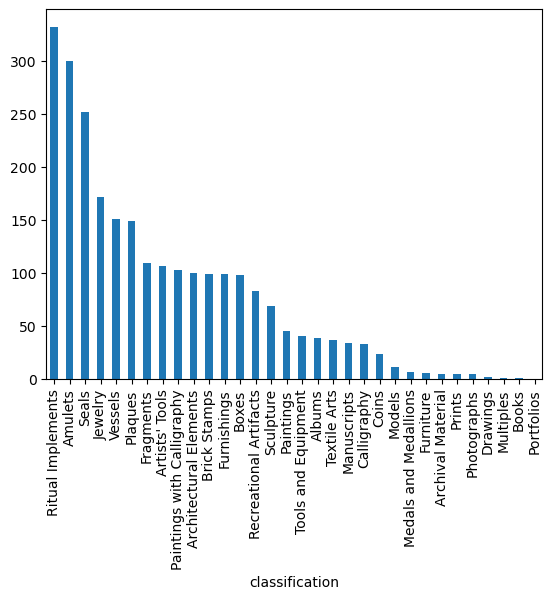

In [86]:
time[(time['datebegin'] != 0) & (time['dateend'] != 0)].groupby('classification')['diff'].mean().sort_values(ascending = False).plot(kind = 'bar');

In [87]:
avg_time = time[(time['datebegin'] != 0) & (time['dateend'] != 0)].groupby('classification')['diff'].mean().sort_values(ascending = False)
avg_time

classification
Ritual Implements             332.222222
Amulets                       300.000000
Seals                         252.000000
Jewelry                       171.454545
Vessels                       151.377622
Plaques                       149.400000
Fragments                     109.906250
Artists' Tools                106.680000
Paintings with Calligraphy    102.700000
Architectural Elements         99.666667
Brick Stamps                   99.000000
Furnishings                    99.000000
Boxes                          98.000000
Recreational Artifacts         83.166667
Sculpture                      69.258333
Paintings                      45.188525
Tools and Equipment            40.631579
Albums                         38.333333
Textile Arts                   37.290323
Manuscripts                    34.470588
Calligraphy                    32.677419
Coins                          23.566869
Models                         11.000000
Medals and Medallions           6.500000
F

Согласно графику, в среднем больше всего лет тратили на создание `Ritual Implements`. Но я бы проверила, нет ли у нас выбросов в данной категории, которые бы так смещали наше среднее.

In [88]:
time[(time['datebegin'] != 0) & (time['dateend'] != 0) & (time['classification'] == 'Ritual Implements')].sort_values(by = 'diff', ascending = False).head()

,classification,datebegin,dateend,diff
5027,Ritual Implements,-1600,-700,900
5035,Ritual Implements,-1600,-1000,600
5034,Ritual Implements,-1600,-1000,600
5031,Ritual Implements,-2500,-1900,600
5028,Ritual Implements,-2500,-1900,600


Построим гистограмму распределения продолжительности создания `Ritual Implements`.

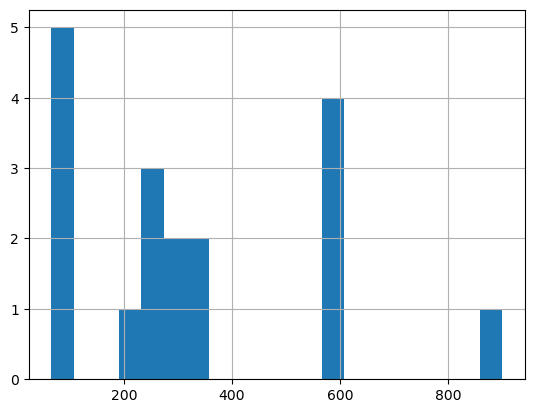

In [89]:
time[(time['datebegin'] != 0) & (time['dateend'] != 0) & (time['classification'] == 'Ritual Implements')]['diff'].sort_values().hist(bins = 20);

Видим, что распредление несимметричное, есть один явный выброс, что явно может смещать наш результат.

Проверим то же самое, только для остальных категорий экспонатов.

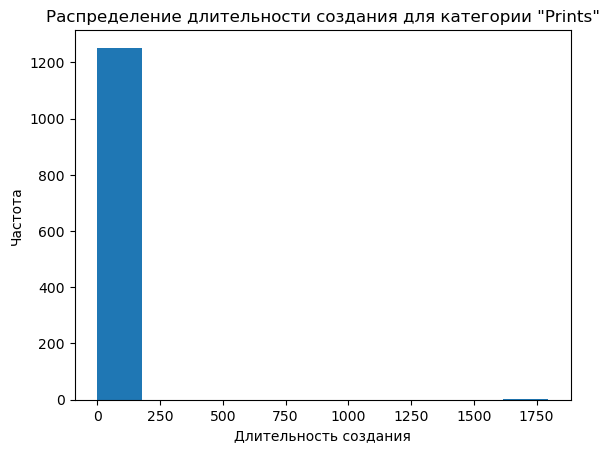

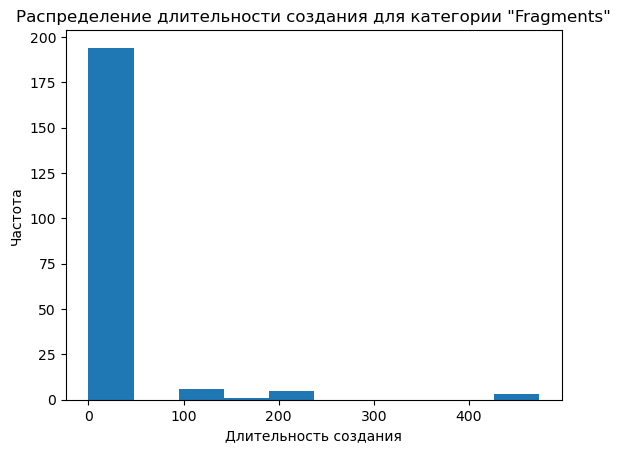

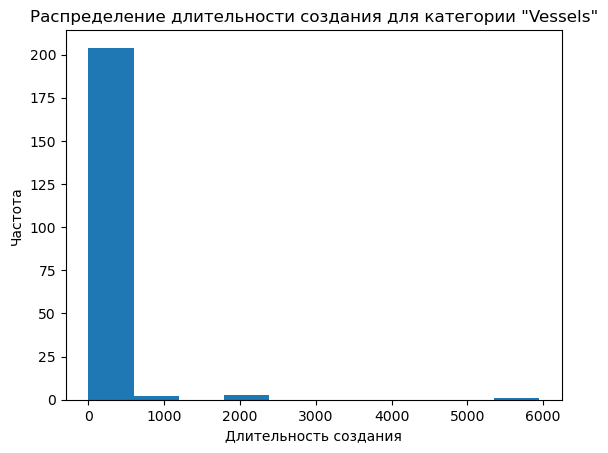

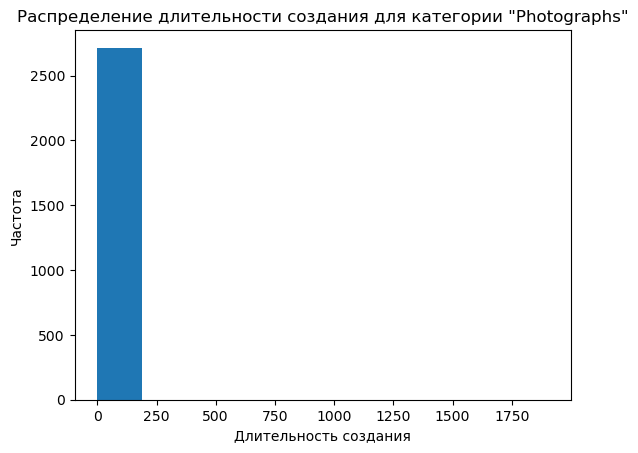

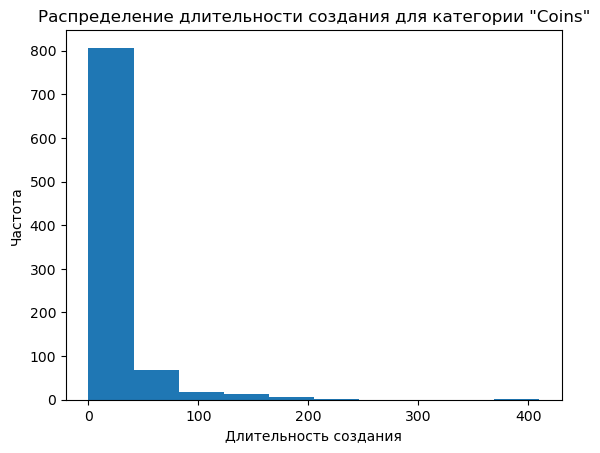

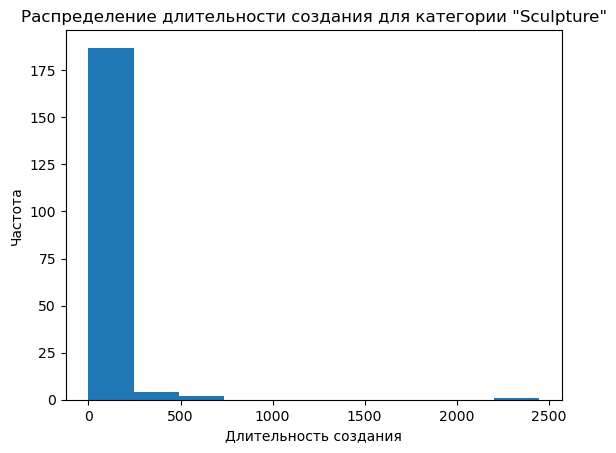

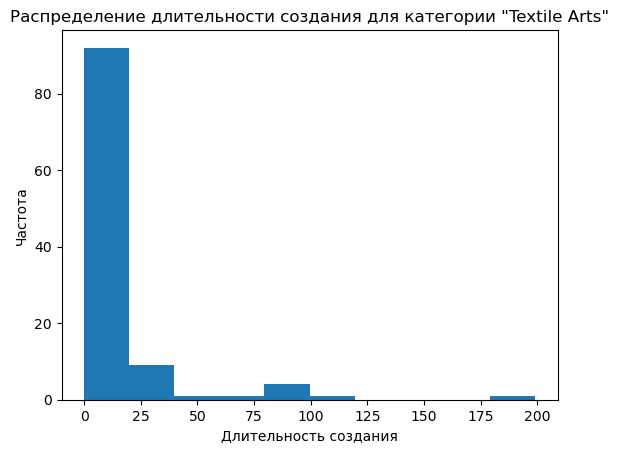

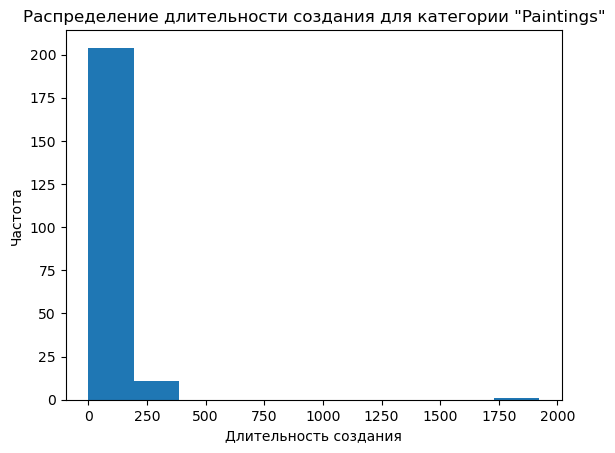

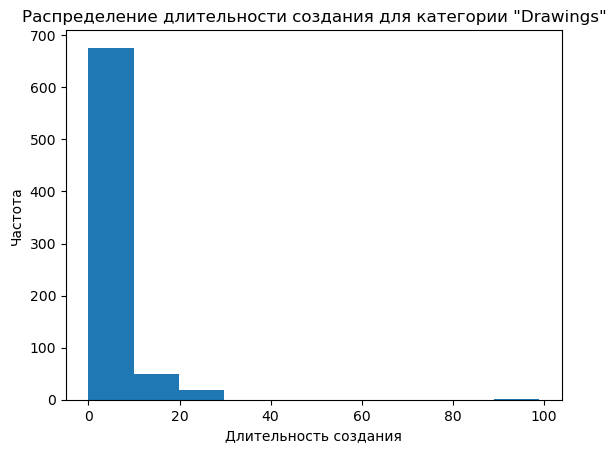

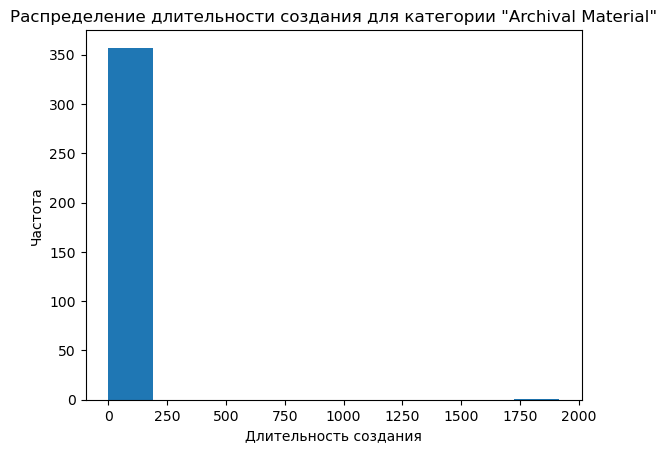

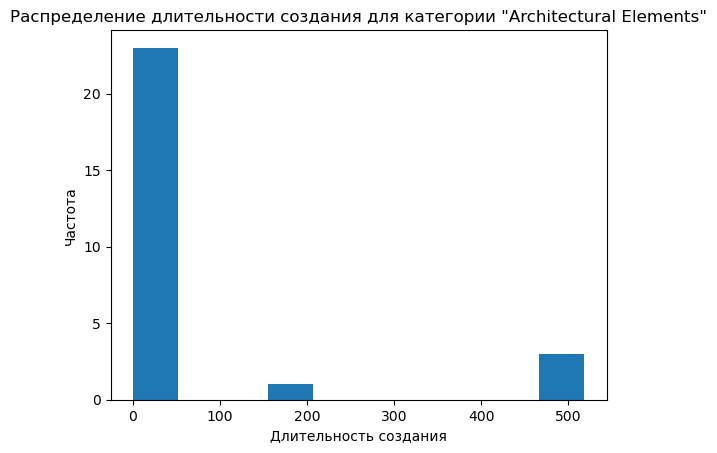

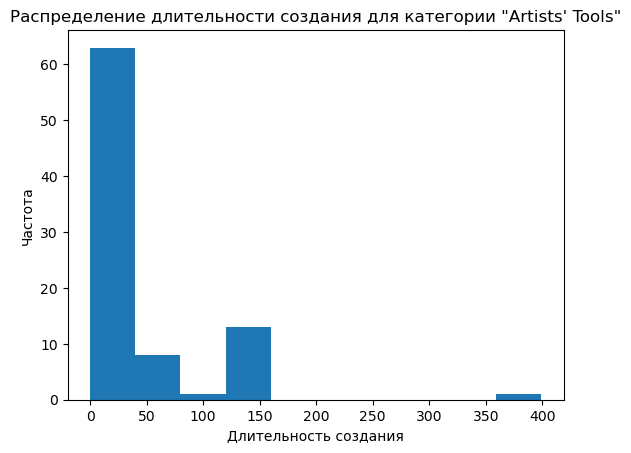

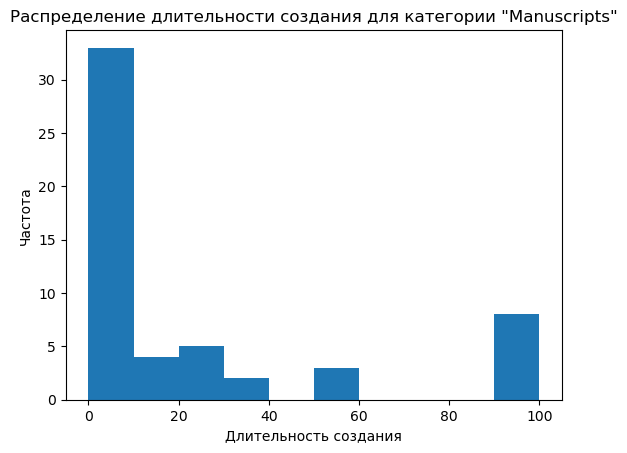

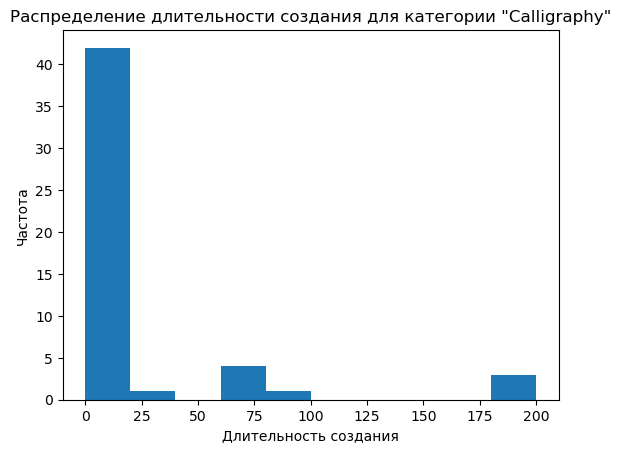

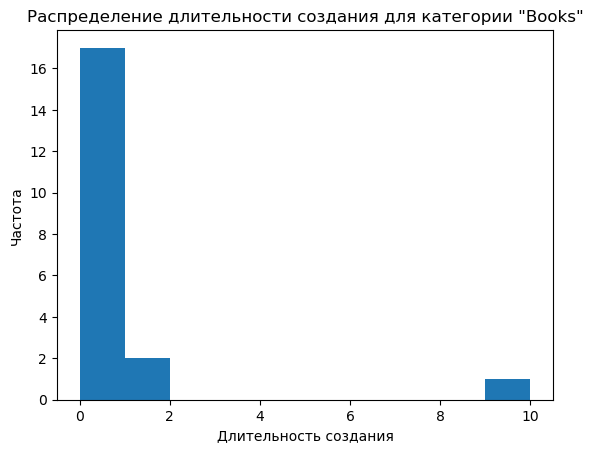

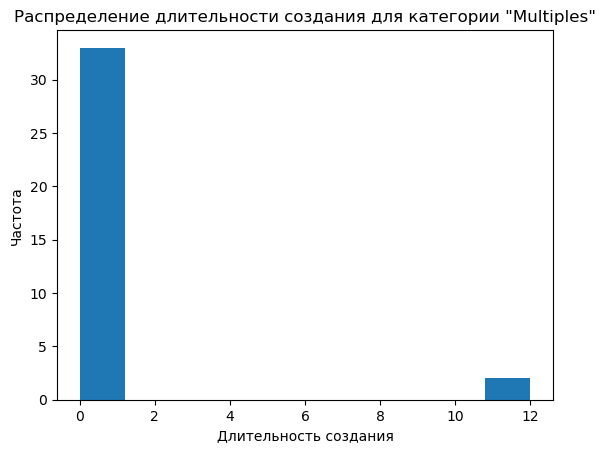

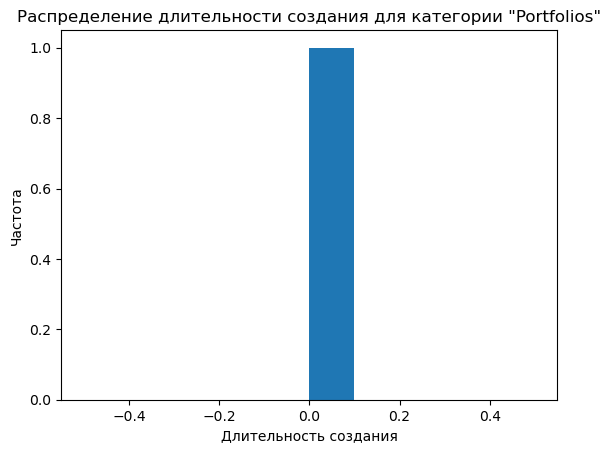

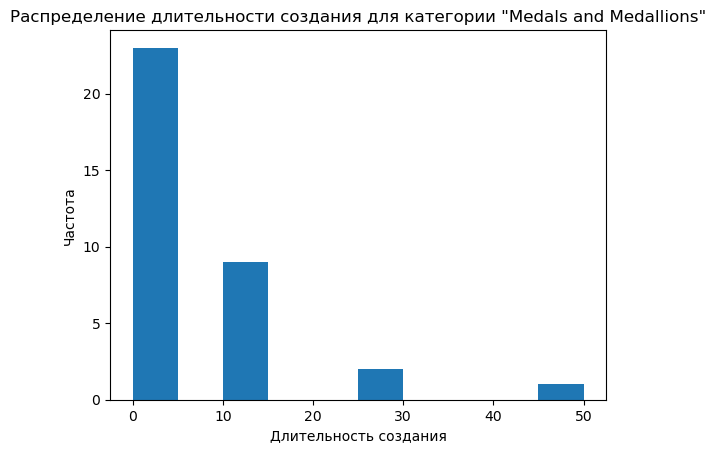

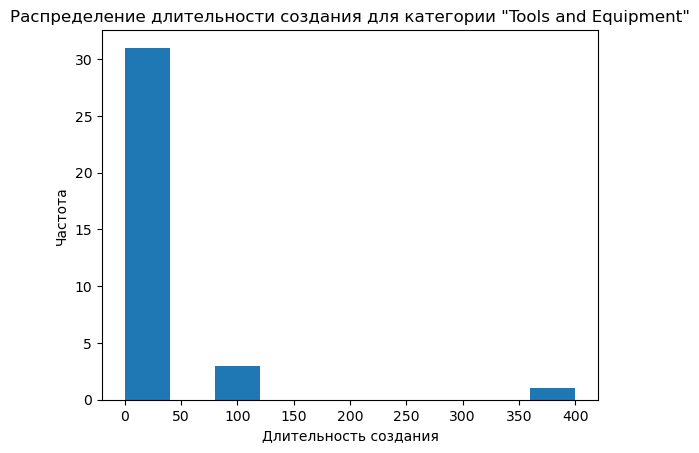

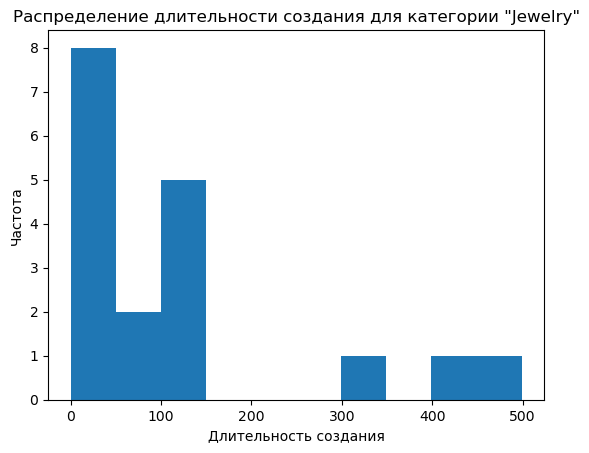

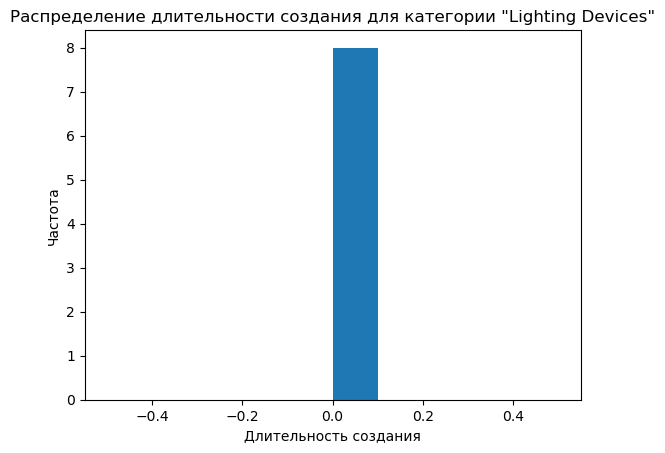

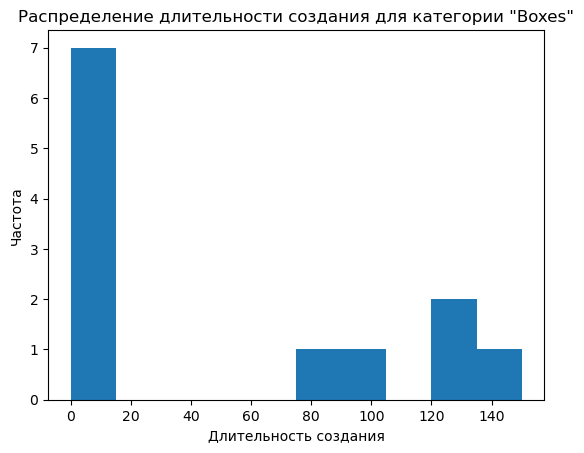

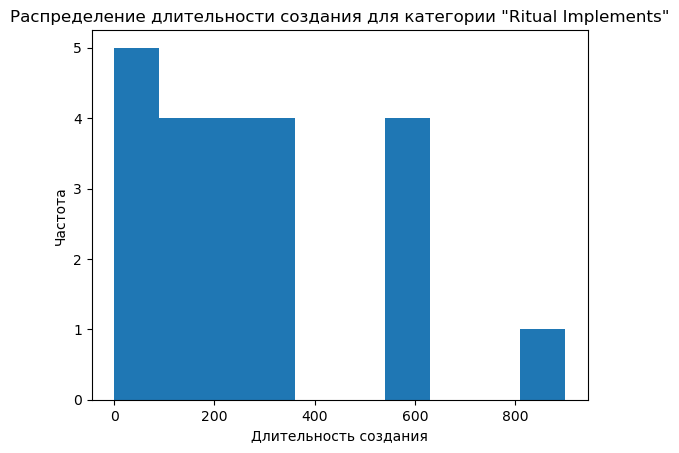

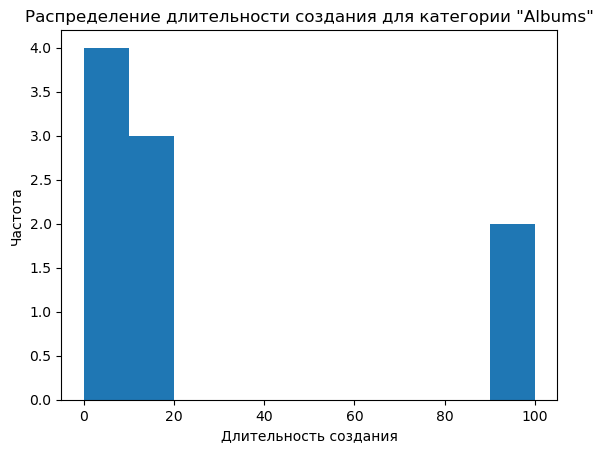

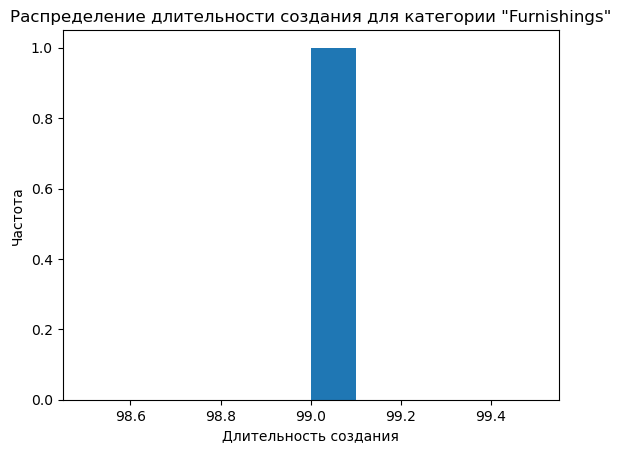

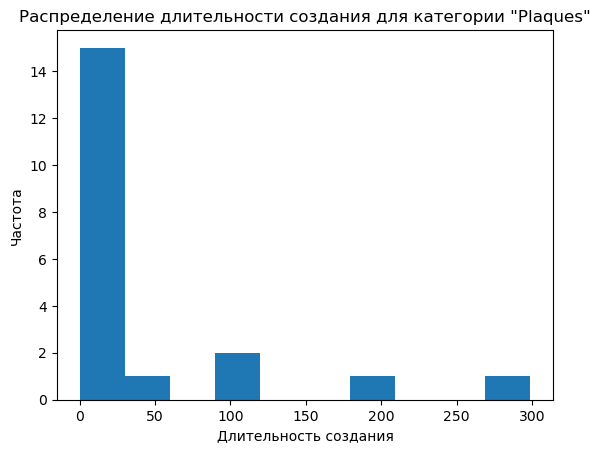

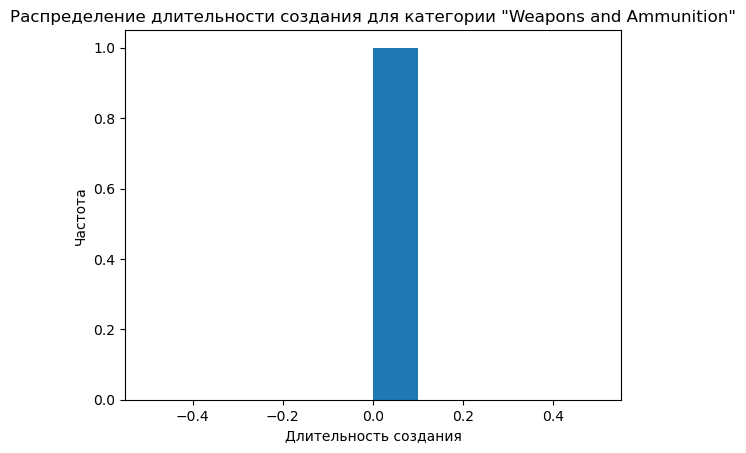

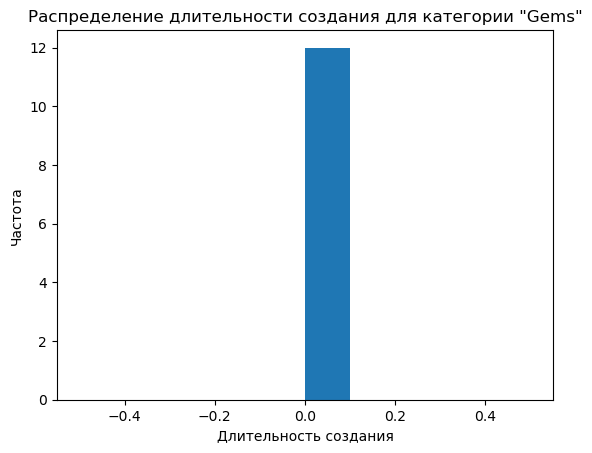

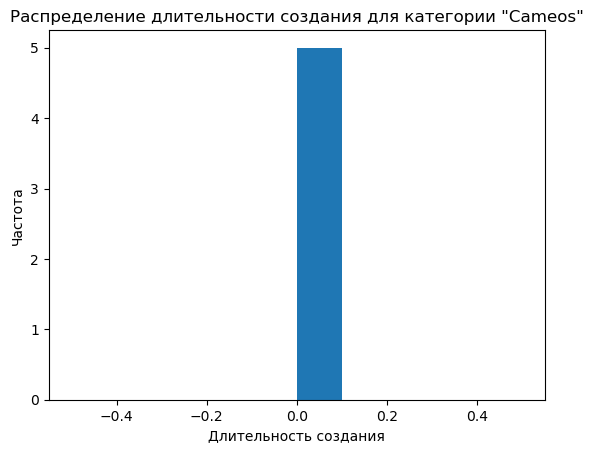

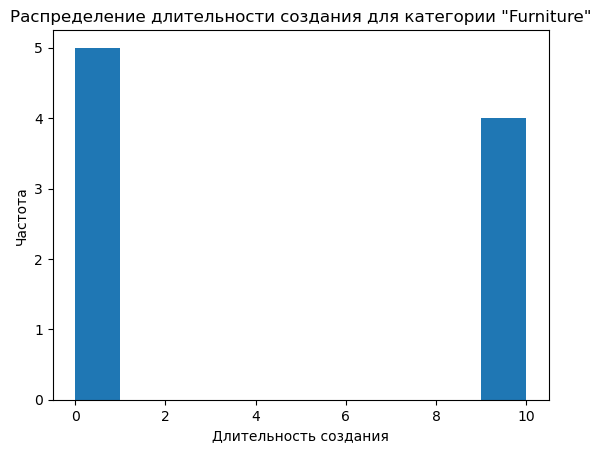

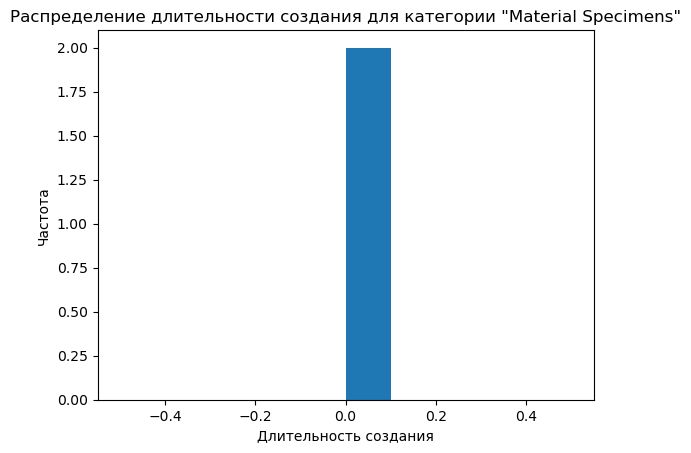

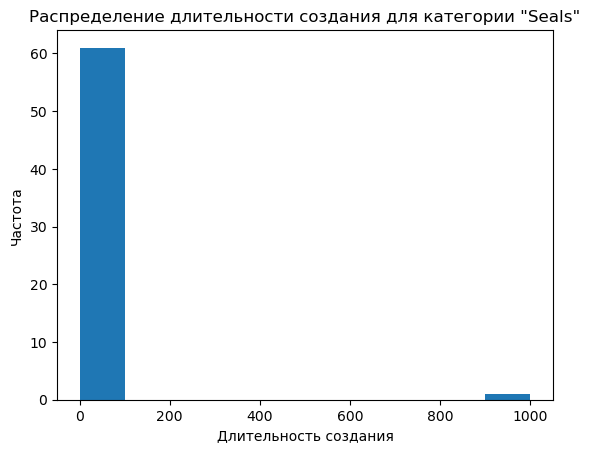

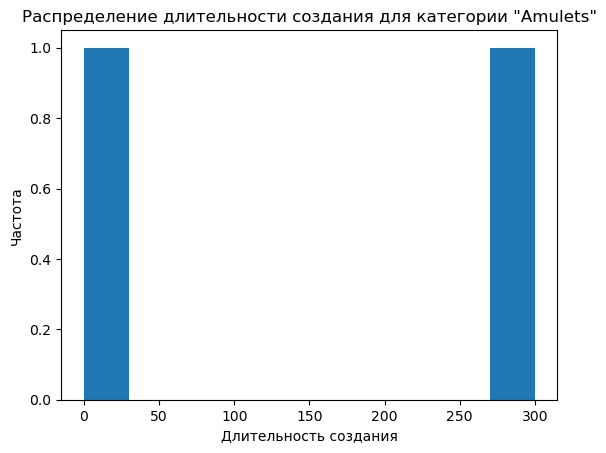

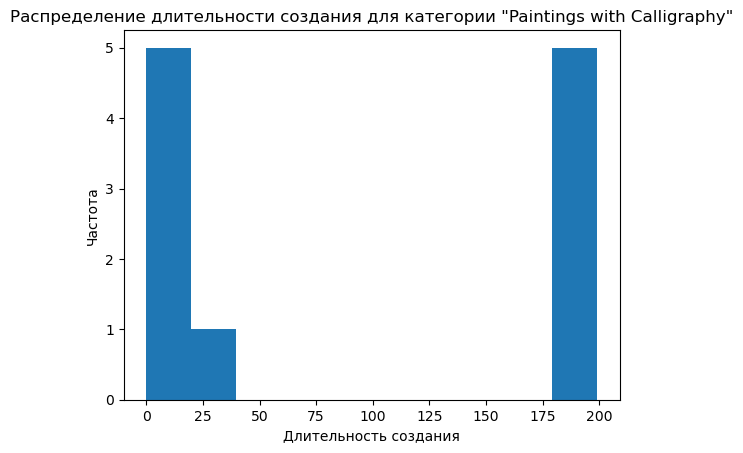

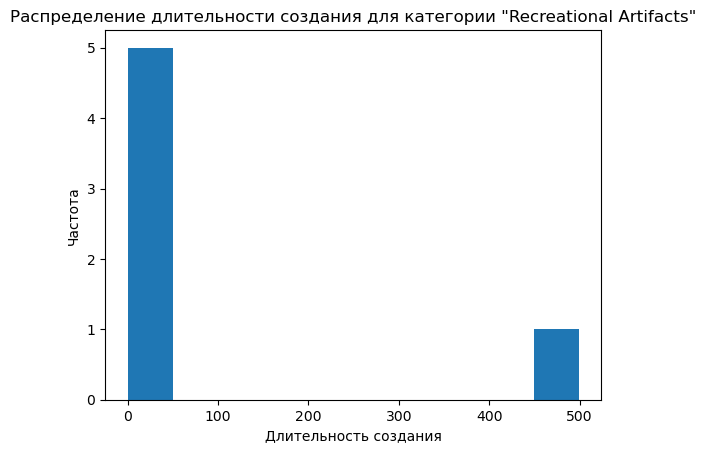

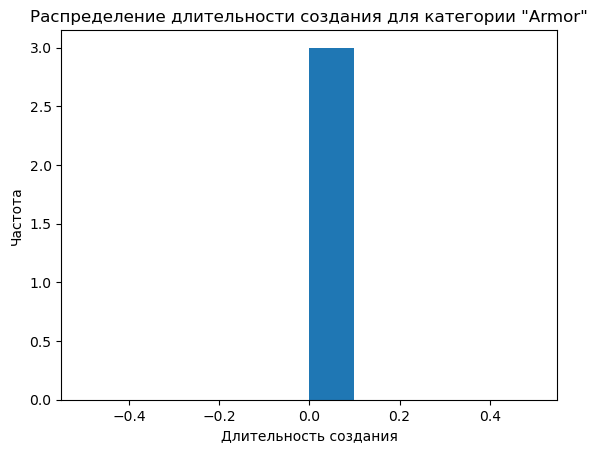

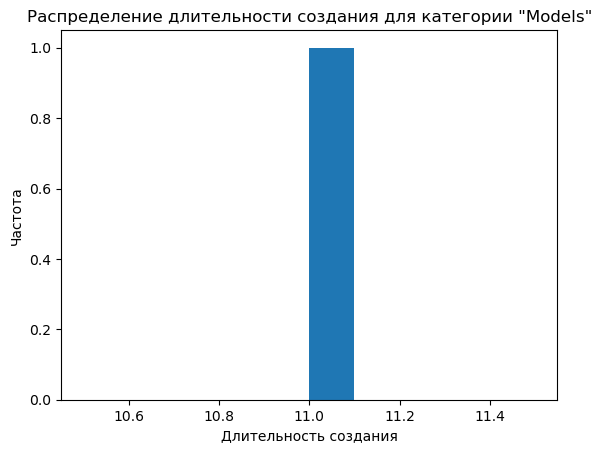

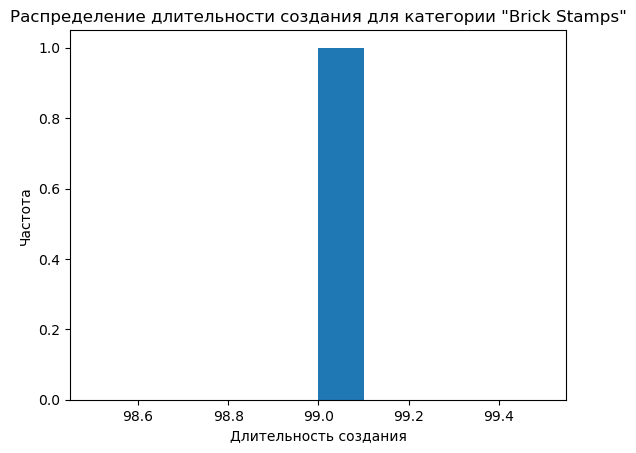

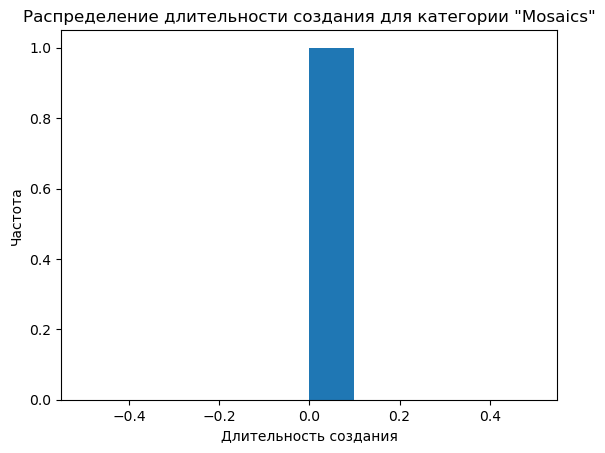

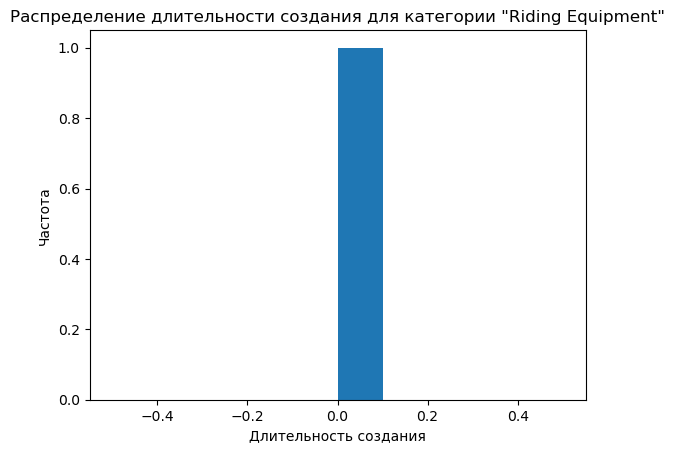

In [90]:
import matplotlib.pyplot as plt

time_filt = time[(time['datebegin'] != 0) & (time['dateend'] != 0)]

# получаю уникальные значения категорий
categories = time['classification'].unique()

# создаю гистограммы для каждой категории
for category in categories:
    plt.figure()  
    time[time['classification'] == category]['diff'].plot(kind='hist')
    plt.xlabel('Длительность создания')
    plt.ylabel('Частота')
    plt.title(f'Распределение длительности создания для категории "{category}"')

# вывожу гистограммы
plt.show()


В общем, нигде не наблюдается нормальное распрделение. Поэтому без дополнительной нормализации данных мы не можем что-то утвержать. В том числе из-за очень большой разницы в количестве вхождений той или иной классификации.

In [91]:
time[(time['datebegin'] != 0) & (time['dateend'] != 0)]['classification'].value_counts()

Photographs                   2625
Prints                         892
Coins                          658
Drawings                       537
Archival Material              223
Vessels                        143
Paintings                      122
Sculpture                      120
Multiples                       35
Manuscripts                     34
Fragments                       32
Textile Arts                    31
Calligraphy                     31
Medals and Medallions           30
Artists' Tools                  25
Architectural Elements          21
Tools and Equipment             19
Books                           19
Ritual Implements               18
Jewelry                         11
Paintings with Calligraphy      10
Furniture                        7
Albums                           6
Boxes                            6
Recreational Artifacts           6
Plaques                          5
Seals                            4
Brick Stamps                     1
Portfolios          

Но в рамках моего проекта отметим, что в среднем больше всего времени тратили на `Ritual Implements`, что может быть связано со сложностью изготовления, использованием специфических материалов и требованиями к точности и детаялм.

In [92]:
avg_time.head(1)

classification
Ritual Implements    332.222222
Name: diff, dtype: float64

В то время как меньше всего времени тратили на `Books`. Например, экспонат с [id 219559](https://harvardartmuseums.org/collections/object/219559).

In [99]:
avg_time.tail(2)

classification
Books         0.631579
Portfolios    0.000000
Name: diff, dtype: float64

<a id='5.4'></a>
### [Цветовые палитры культур](#0)

Для этого воспользуюсь столбцом `colors_of_object`. Посмотрю уникальные цвета, которые встречались в работах каждой культуры (для которой в ячейке было что-то отличное от 0, то есть были какие-то сведения)

In [100]:
palitra = {}

# создаю словарь с вида {культура : все возможные цвета}
for i in range(len(clean['colors_of_object'])):
    if clean['colors_of_object'].iloc[i] == 0:
        continue
    else:
        unique_colors = list(set(clean['colors_of_object'].iloc[i].split(', ')))
        palitra[clean['primary_culture'].iloc[i]] = palitra.get(clean['primary_culture'].iloc[i], []) + unique_colors

In [101]:
palitra_count = {}

# создаю словарь с вида {культура : {цвет : кол-во использования}}
for culture, colors in palitra.items():
    for color in colors:
        palitra_count[culture] = palitra_count.get(culture, {})
        if color not in palitra_count[culture]:
            palitra_count[culture][color] = palitra[culture].count(color)

palitra_count

{'American': {'#4b4b32': 180,
  '#96967d': 246,
  '#64644b': 215,
  '#191919': 1277,
  '#e1c8c8': 114,
  '#c8c896': 11,
  '#190000': 92,
  '#7d7d4b': 7,
  '#324b19': 3,
  '#646432': 8,
  '#324b00': 2,
  '#afaf96': 337,
  '#969696': 1651,
  '#afafaf': 1614,
  '#c8af64': 11,
  '#c8c8c8': 1581,
  '#e1c8af': 205,
  '#af7d4b': 33,
  '#e1e1e1': 1459,
  '#4b4b00': 3,
  '#644b19': 22,
  '#af9696': 51,
  '#af9664': 62,
  '#7d6432': 41,
  '#967d4b': 57,
  '#c8af96': 168,
  '#c8c8af': 276,
  '#967d64': 172,
  '#af967d': 195,
  '#7d7d7d': 1669,
  '#323232': 1458,
  '#646464': 1614,
  '#fafafa': 1247,
  '#4b4b4b': 1531,
  '#7d644b': 162,
  '#323219': 124,
  '#e1e1c8': 300,
  '#644b4b': 119,
  '#967d7d': 84,
  '#966432': 23,
  '#324b7d': 2,
  '#4b647d': 8,
  '#e1c896': 26,
  '#c8644b': 3,
  '#7d4b32': 31,
  '#964b4b': 31,
  '#c8967d': 25,
  '#fae1e1': 44,
  '#7dc896': 1,
  '#afc8af': 6,
  '#324b32': 9,
  '#c8e1c8': 5,
  '#199664': 1,
  '#96af96': 9,
  '#32644b': 1,
  '#7d7d64': 235,
  '#af964b': 6,


In [102]:
palitra_count_dict = {}

# сортирую значения словари словаря с цветами в порядке убывания кол-ва использования цвета
for culture, colors in palitra_count.items():    
    palitra_count_dict[culture] = sorted(colors, key = colors.get, reverse = True)
palitra_count_dict

{'American': ['#7d7d7d',
  '#969696',
  '#afafaf',
  '#646464',
  '#c8c8c8',
  '#4b4b4b',
  '#e1e1e1',
  '#323232',
  '#191919',
  '#fafafa',
  '#000000',
  '#afaf96',
  '#e1e1c8',
  '#c8c8af',
  '#96967d',
  '#7d7d64',
  '#64644b',
  '#e1c8af',
  '#af967d',
  '#4b4b32',
  '#967d64',
  '#c8af96',
  '#7d644b',
  '#323219',
  '#644b32',
  '#644b4b',
  '#e1c8c8',
  '#7d6464',
  '#4b3232',
  '#c8afaf',
  '#190000',
  '#967d7d',
  '#000019',
  '#321919',
  '#4b3219',
  '#af9664',
  '#967d4b',
  '#fafae1',
  '#af9696',
  '#191900',
  '#fae1e1',
  '#c8af7d',
  '#7d6432',
  '#af7d4b',
  '#7d4b32',
  '#964b4b',
  '#af7d64',
  '#e1c896',
  '#c8967d',
  '#7d9696',
  '#4b6464',
  '#966432',
  '#644b19',
  '#96644b',
  '#c89664',
  '#afafc8',
  '#324b4b',
  '#191932',
  '#961919',
  '#fae1c8',
  '#647d7d',
  '#e1af96',
  '#c8c8e1',
  '#32324b',
  '#e1af7d',
  '#96afaf',
  '#afc8c8',
  '#4b4b64',
  '#af6464',
  '#19324b',
  '#643219',
  '#7d1919',
  '#321900',
  '#324b64',
  '#963232',
  '#c89696',


In [ ]:
palitra_count_dict

Выведем для каждой культуры по 3 цвета, которые встречаются в её работах чаще всего.

In [103]:
for culture, colors in palitra_count_dict.items():
    print(f'Культура: {culture}')
    lst_colors  = colors[:3]
    i = 1
    for color in lst_colors:
        count = palitra_count[culture][color]
        print(f'Основной цвет {i}: {color}, использовался {count} раз')
        i += 1

Культура: American
Основной цвет 1: #7d7d7d, использовался 1669 раз
Основной цвет 2: #969696, использовался 1651 раз
Основной цвет 3: #afafaf, использовался 1614 раз
Культура: 0
Основной цвет 1: #644b32, использовался 61 раз
Основной цвет 2: #c8c8c8, использовался 59 раз
Основной цвет 3: #af967d, использовался 53 раз
Культура: British, English
Основной цвет 1: #c8c8af, использовался 3 раз
Основной цвет 2: #7d7d64, использовался 2 раз
Основной цвет 3: #96967d, использовался 2 раз
Культура: Greek
Основной цвет 1: #000000, использовался 435 раз
Основной цвет 2: #000019, использовался 231 раз
Основной цвет 3: #190000, использовался 196 раз
Культура: Roman Republican
Основной цвет 1: #000000, использовался 29 раз
Основной цвет 2: #190000, использовался 23 раз
Основной цвет 3: #7d6464, использовался 16 раз
Культура: Roman Provincial
Основной цвет 1: #000000, использовался 115 раз
Основной цвет 2: #190000, использовался 35 раз
Основной цвет 3: #7d644b, использовался 27 раз
Культура: Roman Imp

Вот такая, например, цветовая палитра Америки:
![Палитра америки](project_pictures/american_colors.png)

Выглядит, конечно, не очень радужно и ярко. В основном это всё оттенки, похожие друг на друга. Такой результат я могу объяснить тем, что картина строится на тенях и оттенках. Ничто не придаёт картине жизни лучше, чем её максимальное приближение к реальности выделением деталей: тень от объекта, затемнение в какой-то области и так далее. Скорее всего данные цвета просто чаще остальных смешивались  другими и были переходными (от белого, к чёрному, например), поэтому и использовались наибольшее кол-во раз.

<a id='5.5'></a>
### [Департаменты экспонатов](#0)

Мне стало интересно посмотреть, в каком `department` и `division` больше всего экспонатов.

In [104]:
pivot_table = pd.pivot_table(clean, 
                             index='department', 
                             columns='division', 
                             values='id', 
                             aggfunc='count',
                             fill_value=0)

In [105]:
pivot_table = pivot_table[['Asian and Mediterranean Art', 'Modern and Contemporary Art', 'European and American Art']]
pivot_table['summa'] = pivot_table['Asian and Mediterranean Art'] + pivot_table['Modern and Contemporary Art'] + pivot_table['European and American Art']

In [106]:
pivot_table.sort_values(by = 'summa')

division,Asian and Mediterranean Art,Modern and Contemporary Art,European and American Art,summa
department,,,,
Straus Center for Conservation and Technical Studies,0,0,0,0
Harvard University Portrait Collection,0,7,2,9
"Department of American Paintings, Sculpture & Decorative Arts",0,6,41,47
Department of Modern & Contemporary Art,0,59,0,59
Department of Islamic & Later Indian Art,113,0,0,113
Archives,0,169,0,169
"Department of Paintings, Sculpture & Decorative Arts",0,6,238,244
Department of Drawings,0,187,205,392
Department of Prints,0,179,419,598


Итак. Сразу напомню, что в моём случае 0 может означать не только отсутсвие экмпонатов в департаменте, но и просто отсутсвие данных в таблице, поэтому юудем рассматривать строки, в которых есть хоть каике-то данные, отличные от 0.

Наибольшее кол-во экспонатов находится в `Department of Photographs`, при этом сразу из двух подразделений: `Modern and Contemporary Art` и `European and American Art`, что действительно похоже на правду. Так как фотографии легче хранить, то их действительно может быть намного больше, чем, например рисунков в депратаменте `Department of Drawings`.

Посмотрим, какие культуры представлены в каждом департаменте.

In [107]:
pivot_table_2 = pd.pivot_table(clean, 
                             index='department', 
                             columns='primary_culture', 
                             values='id', 
                             aggfunc='count',
                             fill_value=0)

pivot_table_2

primary_culture,0,Afghan,American,American?,Anatolian,Arab,Assyrian,Austrian,Avar,Belgian,Berber,Brazilian,British,"British, English","British, Scottish",British?,Byzantine,Cambodian,Canadian,Celtic,Central Asian,Chinese,Coptic,Costa Rican,Cuban,Cycladic,Danish,Dutch,East Asian,Egyptian,Ethiopian,Etruscan,European,European?,Flemish,French,Gandharan,German,German?,Graeco-Bactrian,Graeco-Roman,Greek,Helladic,Hellenistic,Hispano-Moorish,Hungarian,Iberian,Indian,Indo-Scythian,Irish,Islamic,Israeli,Italian,"Italian, Neapolitan",Italian?,Italic,Japanese,Jewish,Judaean,Korean,Mexican,Minoan,Moroccan,Mycenaean,Netherlandish,Norwegian,Ostrogoth,Ottoman,Parthian,Persian,Polish,Portuguese?,Punic,Roman,Roman Imperial,Roman Provincial,Roman Republican,Romanian,Russian,Sasanian,Seleucid,Siculo-Punic,Spanish,Spanish?,Swedish,Swedish?,Swiss,Syrian,Thai,Tibetan,Turkish,Unidentified culture,Vandalic
department,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Archives,0,0,165,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Busch-Reisinger Museum,39,0,386,5,0,0,0,6,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,0,0,0,0,0,0,1,3,0,1203,89,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,2,8,0,7,0,0,0,0,0,0
"Department of American Paintings, Sculpture & Decorative Arts",0,0,46,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Department of Ancient and Byzantine Art & Numismatics,22,0,0,0,1,0,1,0,3,0,5,0,0,0,0,0,131,0,0,2,0,0,1,0,0,1,0,0,1,5,0,1,12,0,0,0,0,0,0,1,2,482,6,5,0,0,2,0,1,0,0,0,1,0,0,4,0,1,1,0,0,1,0,11,0,0,3,0,6,0,0,0,6,134,68,115,29,0,0,0,4,3,0,0,0,0,0,1,0,0,0,11,1
Department of Asian Art,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,32,372,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,566,0,0,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,7,0,0,0
Department of Drawings,0,0,302,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,1,25,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6,0,0,0,0,0,0
Department of Islamic & Later Indian Art,2,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,16,1,17,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0
Department of Modern & Contemporary Art,3,0,31,0,0,0,0,1,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0
"Department of Paintings, Sculpture & Decorative Arts",3,0,0,0,0,0,0,1,0,0,0,0,65,0,2,0,1,0,0,0,0,1,0,1,1,0,2,6,0,0,0,0,4,0,1,60,0,1,0,0,0,1,0,0,3,0,0,2,0,1,0,0,63,1,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,0,0,0,7,0,0,1,0,0,0,0,0,6,0


В каждом департаменте присутствуют некоторые культуры, но не во всех. Опять таки, некоторые могут быть записаны как 0, только потому что нет данных в первоначальной таблице.

<a id='5.6'></a>
### [Должности `people`](#0)

Мы уже немного завтрагивали извлечённый `json` с информацией, о людях, которые были причастны к экспонату. Я хочу посмотреть, авторы из каких стран чаще всего встречаются в датасете.

In [108]:
clean.groupby('birth_country')['id'].count().sort_values()

birth_country
Middlesex County, England           1
Prussia [now Wroclav, Poland]       1
Poland(?)                           1
Pennsylvania, USA                   1
Holland                             1
                                 ... 
CA                                237
PA                                328
Germany                           364
NY                               1038
0                                4463
Name: id, Length: 115, dtype: int64

Исходя из этой таблички, большая часть деятелей искусства была родом из `NY` (Нью-Юорка). Разрыв с `PA` (предположительно, Панама) достаточно большой, так что в рамках данного датасета почти тоно можно сказать, что этот вывод имеет место быть. Однако, если посмотореть на уникальные значения этого столбца, то мы снова столкнёмся с разнородностью данных. Нью-Йорк может быть записан несколькими способами: `NY`, `N.Y., USA`, `New York`. Так что на самом деле цифры в таблице должны быть ещё больше.

In [109]:
clean['birth_country'].unique()

array(['Italy', 0, 'Ohio', 'Gaul', 'Lithuania', 'France', 'IL',
       'N.Y., USA',
       'Ukrainian Soviet Socialist Republic (now Dnipro, Ukraine)', 'NY',
       'CA', 'Mass., USA', 'New Hampshire', 'Ohio, U.S.A.', 'Germany',
       'near Zwickau, Germany', 'Austria', 'England',
       'near Vienna, Austria', 'Sweden', 'Poland', 'Hungary', 'Berlin',
       'Czech Republic', 'MA', 'New York', 'Brittany, France', 'Japan',
       'Spain', 'Wisconsin', 'Massachusetts', 'California', 'D.C.', 'MS',
       'Russia', 'OH', 'nr Memmlingen', 'Ireland',
       'East Prussia [now Gvardeysk, Russia]',
       'West Prussia [now Poland]', 'Switzerland', 'Norway', 'PA',
       'Niigata-ken', 'Pennsylvania', 'Nebraska', 'New Jersey',
       'Illinois', 'Indiana', 'Arizona', 'Maryland', 'Brazil', 'Missouri',
       'Michigan', 'The Netherlands', 'Oregon', 'Nova Scotia',
       'Illinois, USA', 'Latvia', 'Prussia [now Miedzychod, Poland]',
       'Mo., USA', 'Netherlands', 'WV', 'CT',
       'Prussia 

<a id='5.7'></a>
### [Плодотворность года `people`](#0)

Выясним, в какой год Гарвардский музей приобрёл наибольшее кол-во экспонатов и каким способом эти экспонамты были получены.

In [110]:
clean['accessionyear'].value_counts()

0       1620
2011    1555
2001     397
1933     263
1963     241
        ... 
1913       1
1917       1
1909       1
1945       1
1926       1
Name: accessionyear, Length: 108, dtype: int64

In [111]:
clean['accessionmethod'].value_counts()

Gift                                3544
Transfer                            1794
0                                    756
Bequest                              715
Purchase                             503
Unidentified                         121
Partial Gift/Partial Purchase         27
Long Term Loan and Promised Gift       9
Found in Collection                    4
Commission                             1
Name: accessionmethod, dtype: int64

Из этих вух табличек можем сделать вывод, что самым плодотворным годом для музея стал 2011, когда коллекция экспонатов пополнилась на 1462 экспоната. Разница со следующим по величине годом достаточно большая, поэтому, опять таки, мы можем с большей уверенностью предположить, что это было ействительно так (хотя сделать поправку на ячейки, в которых этих данных не было, тоже стоит).

И также большинство экспонатов музей получил в качестве подарка.

In [112]:
clean[clean['accessionyear'] == 2011]['accessionmethod'].value_counts()

Transfer    1555
Name: accessionmethod, dtype: int64

При этом в год, отметившийся наибольшим приходом экспонатов, все они были транспортированы, а не подарены.

<a id='6'></a>
## [Выводы](#0)

Исследовав такой большой и непростой датасет, могу сказать, что я могу выделить такие его плюсы и минусы.

**Плюсы**
* большой объём (по крайней мере для проекта)
* большое кол-во возможных данных (и я выбрала не все из них)
* большой простор для исследования (как начинающий датасаентист, я начала с чего-то чуть более простого. не дошла до тщательной очистки и унификации, но всё же постаралась сделать всё, что могла)
* разнообразие типа данных (и категориальные, и числовые данные, всегда приятно и удобно работать с разными данными)

**Минусы**
* недостаточная рапрезентативность (нельзя сказать, что мой датасет ни о чём не говорит. но всё же он остаётся лишь небольшой выборкой)
* неунифицированность данных (часто в столбцах встречаются данные, которые могут значить одно и то же, но быть записаны по-разному)

Мои обработка и анализ этих данных, конечно, не являются показательными и наиболее полными, но они тоже имеют право на существование!

Так мы смогли построить небольшие цветовые палитры для отдельных культур, посмтореть на некоторую статичтику кол-ва экспонатов, художников и так далее. 

Я старалась использовать различные приёмы анализа данных, старалась размышлять, задавать вопросы и искать ответы. Надеюсь, у меня получилось) Спасибо!